# Cel pracy

Celem projektu było zbudowanie modeli prognostycznych, które umożliwią przewidywanie dziennej liczby przejazdów oraz liczby przejazdów nocnych (w godzinach 00:00–6:00) na podstawie danych historycznych. Dane obejmują zapis liczby przejazdów w ujęciu godzinowym, które zostały następnie zaggregowane w podziale na okresy doby: dzień (6:00–16:00), wieczór (16:00–24:00) oraz noc (0:00–6:00). Zakres czasowy danych to styczeń 2024 do marzec 2025 – rok 2024 posłużył jako zbiór treningowy, zaś okres od stycznia do marca 2025 jako zbiór testowy do oceny prognoz.

# Import

In [4]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pmdarima import auto_arima
from pmdarima.arima import ndiffs, nsdiffs
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

# Funkcje pomocnicze

In [6]:
# Rozbicie danych godzinowych na pory dnia
def classify_period(hour):
    if 6 <= hour < 16:
        return 'day'
    elif 16 <= hour < 24:
        return 'evening'
    else:
        return 'night'

In [7]:
def apply_classify(df):
    df['period'] = df['hour'].apply(classify_period)
    return df

In [8]:
# Tworzenie wykresów dla reszt modeli
def plot_residuals(model_fit):

    residuals = model_fit.resid[1:]
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    residuals.plot(title='Residuals', ax=ax[0])
    residuals.plot(title='Density', kind='kde', ax=ax[1])
    plt.tight_layout()
    plt.show()

In [9]:
#Tworzenie modelu ARIMA
def train_arima(train_series, test_series, order=(1, 0, 1)):
    model = ARIMA(train_series, order=order)
    fit = model.fit()
    forecast = fit.forecast(len(test_series))
    return forecast, fit

In [10]:
#Tworzenie modelu SARIMA
def train_sarima(train_series, test_series, order=(1, 0, 1), seasonal_order=(1, 0, 1, 7)):
    model = SARIMAX(train_series, order=order, seasonal_order=seasonal_order)
    fit = model.fit()
    forecast = fit.forecast(len(test_series))
    return forecast, fit

In [11]:
#Tworzenie modelu SARIMAX
def train_sarimax(train_series, test_series, exog_train, exog_test,
                  order=(1, 0, 1), seasonal_order=(1, 0, 1, 7)):
    model = SARIMAX(train_series,
                    exog=exog_train,
                    order=order,
                    seasonal_order=seasonal_order)
    fit = model.fit()
    forecast = fit.forecast(len(test_series), exog=exog_test)
    return forecast, fit

In [12]:
#tworzenie statystyk modeli
def evaluate_forecast(y_true, y_pred, printing=True):
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    
    if printing:
        print(f"MAE: {mae:.2f}")
        print(f"MAPE: {mape:.4f}")
    
    return {'mae': mae, 'mape': mape}

In [13]:
#tworzenie wykresow predykcji
def plot_forecast(df, forecast, train_len, title='Forecast'):
    df = df.copy()
    df['forecast'] = [None]*train_len + list(forecast)

    df[['rides', 'forecast']].plot(figsize=(14, 5), title=title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return df

In [14]:
#Funkcja do sprawdzenia wariancji, powstala na skutek podejrzenia potrzeby nalozenia logarytmu na dane
def check_variance_trend(df, label=""):
    df = df.copy()
    df = df.sort_index()

    n = len(df)
    if n < 3:
        print(f"Za mało danych w {label} do analizy.")
        return
    
    part1 = df.iloc[:n//3]['rides']
    part2 = df.iloc[n//3:2*n//3]['rides']
    part3 = df.iloc[2*n//3:]['rides']

    var1 = np.var(part1)
    var2 = np.var(part2)
    var3 = np.var(part3)

    print(f"\n{label} – Wariancje w 3 częściach danych:")
    print(f"  Część 1: {var1:.2f}")
    print(f"  Część 2: {var2:.2f}")
    print(f"  Część 3: {var3:.2f}")

    if var1 < var2 < var3:
        print("Wariancja rośnie, może być potrzeba dokonania transformacji.")
    else:
        print("Wariancja wygląda na stabilną – transformacja może nie być konieczna.")

# Przygotowanie danych
Dane zostały wczytane i przygotowane do dalszego modelowania.

In [16]:
def load_files():
    all_dfs = []
    for year in [2024, 2025]:
        for month in range(1, 13):
            file_name = f"yellow_tripdata_{year}-{month:02d}.parquet"
            if os.path.exists(file_name):
                df = pd.read_parquet(file_name)
                all_dfs.append(df)
            else:
                print(f"Plik {file_name} nie istnieje – pomijam.")
    combined_df = pd.concat(all_dfs, ignore_index=True)
    return combined_df

In [17]:
# Wczytanie danych
df = load_files()

Plik yellow_tripdata_2025-04.parquet nie istnieje – pomijam.
Plik yellow_tripdata_2025-05.parquet nie istnieje – pomijam.
Plik yellow_tripdata_2025-06.parquet nie istnieje – pomijam.
Plik yellow_tripdata_2025-07.parquet nie istnieje – pomijam.
Plik yellow_tripdata_2025-08.parquet nie istnieje – pomijam.
Plik yellow_tripdata_2025-09.parquet nie istnieje – pomijam.
Plik yellow_tripdata_2025-10.parquet nie istnieje – pomijam.
Plik yellow_tripdata_2025-11.parquet nie istnieje – pomijam.
Plik yellow_tripdata_2025-12.parquet nie istnieje – pomijam.


In [18]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52367746 entries, 0 to 52367745
Data columns (total 20 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int32         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int32         
 8   DOLocationID           int32         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  Airport_fee         

In [20]:
df = df[['tpep_pickup_datetime']]

In [21]:
print(df.head())

  tpep_pickup_datetime
0  2024-01-01 00:57:55
1  2024-01-01 00:03:00
2  2024-01-01 00:17:06
3  2024-01-01 00:36:38
4  2024-01-01 00:46:51


Sprawdzenie czy są nulle oraz czy dane są napewno prawidłowe, to znaczy czy są w odpowiednim zakresie.

In [23]:
print(df['tpep_pickup_datetime'].isna().sum())

0


In [24]:
print(df['tpep_pickup_datetime'].min())
print(df['tpep_pickup_datetime'].max())

2002-12-31 16:46:07
2026-06-26 23:53:12


In [25]:
df = df[(df['tpep_pickup_datetime'] >= '2024-01-01') & 
        (df['tpep_pickup_datetime'] < '2025-04-01')]

In [26]:
print(df['tpep_pickup_datetime'].min())
print(df['tpep_pickup_datetime'].max())

2024-01-01 00:00:00
2025-03-31 23:59:59


In [27]:
df['date'] = df['tpep_pickup_datetime'].dt.date
df['hour'] = df['tpep_pickup_datetime'].dt.hour

In [28]:
df = apply_classify(df)

Dane zostały ograniczone do odpowiedniego przedziału i została nałożona klasyfikacja danych ze względu na okres dnia (`period`). Dane zostały sklasyfikowane na trzy różne okresy: od 24 do 6 - `night`; od 6 do 16 - `day`; od 16 do 24 - `evening`.

In [30]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 52367691 entries, 0 to 52367745
Data columns (total 4 columns):
 #   Column                Dtype         
---  ------                -----         
 0   tpep_pickup_datetime  datetime64[us]
 1   date                  object        
 2   hour                  int32         
 3   period                object        
dtypes: datetime64[us](1), int32(1), object(2)
memory usage: 1.8+ GB
None


In [31]:
print(df.head())

  tpep_pickup_datetime        date  hour period
0  2024-01-01 00:57:55  2024-01-01     0  night
1  2024-01-01 00:03:00  2024-01-01     0  night
2  2024-01-01 00:17:06  2024-01-01     0  night
3  2024-01-01 00:36:38  2024-01-01     0  night
4  2024-01-01 00:46:51  2024-01-01     0  night


In [32]:
daily_period_counts = df.groupby(['date', 'period']).size().reset_index(name='rides')
print(daily_period_counts.head())

         date   period  rides
0  2024-01-01      day  27237
1  2024-01-01  evening  23959
2  2024-01-01    night  29817
3  2024-01-02      day  40528
4  2024-01-02  evening  32190


In [33]:
daily_total = df.groupby('date').size().reset_index(name='rides')
daily_total['period'] = 'whole_day'  # dodaj etykietę
daily_total = daily_total[['date', 'period', 'rides']]  # uporządkuj kolumny
print(daily_total.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456 entries, 0 to 455
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    456 non-null    object
 1   period  456 non-null    object
 2   rides   456 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 10.8+ KB
None


In [34]:
all_periods = pd.concat([daily_period_counts, daily_total], ignore_index=True)

In [35]:
all_periods['date'] = pd.to_datetime(all_periods['date'])
all_periods['day_type'] = all_periods['date'].dt.weekday.apply(lambda x: 'weekend' if x >= 5 else 'weekday')

all_periods['is_weekend'] = (all_periods['day_type'] == 'weekend').astype(int)

period_order = ['day', 'evening', 'night', 'whole_day']
all_periods['period'] = pd.Categorical(all_periods['period'], categories=period_order, ordered=True)
all_periods = all_periods.sort_values(by=['date', 'period']).reset_index(drop=True)
print(all_periods.head())

        date     period  rides day_type  is_weekend
0 2024-01-01        day  27237  weekday           0
1 2024-01-01    evening  23959  weekday           0
2 2024-01-01      night  29817  weekday           0
3 2024-01-01  whole_day  81013  weekday           0
4 2024-01-02        day  40528  weekday           0


Stworzony został zbiór z pełnymi danymi, lecz dla pełnej analizy zostanie on rozbity na podzbiory, dla każdego `period`.

In [37]:
day_df = all_periods[all_periods['period'] == 'day'].copy().reset_index(drop=True)
evening_df = all_periods[all_periods['period'] == 'evening'].copy().reset_index(drop=True)
night_df = all_periods[all_periods['period'] == 'night'].copy().reset_index(drop=True)
whole_day_df = all_periods[all_periods['period'] == 'whole_day'].copy().reset_index(drop=True)
for df in [day_df, evening_df, night_df, whole_day_df]:
    df.set_index('date', inplace=True)
    df.sort_index(inplace=True)   

Stworzenie dodatkowego zbioru dla analiz.


In [39]:
periods_data = all_periods[all_periods['period'] != 'whole_day']
print(periods_data.head())

        date   period  rides day_type  is_weekend
0 2024-01-01      day  27237  weekday           0
1 2024-01-01  evening  23959  weekday           0
2 2024-01-01    night  29817  weekday           0
4 2024-01-02      day  40528  weekday           0
5 2024-01-02  evening  32190  weekday           0


# Analiza danych
W tej sekcji zostaną przedstawione informacje na temat danych, takie jak wykresy czy statystyki.

### 1. Wykresy trendu

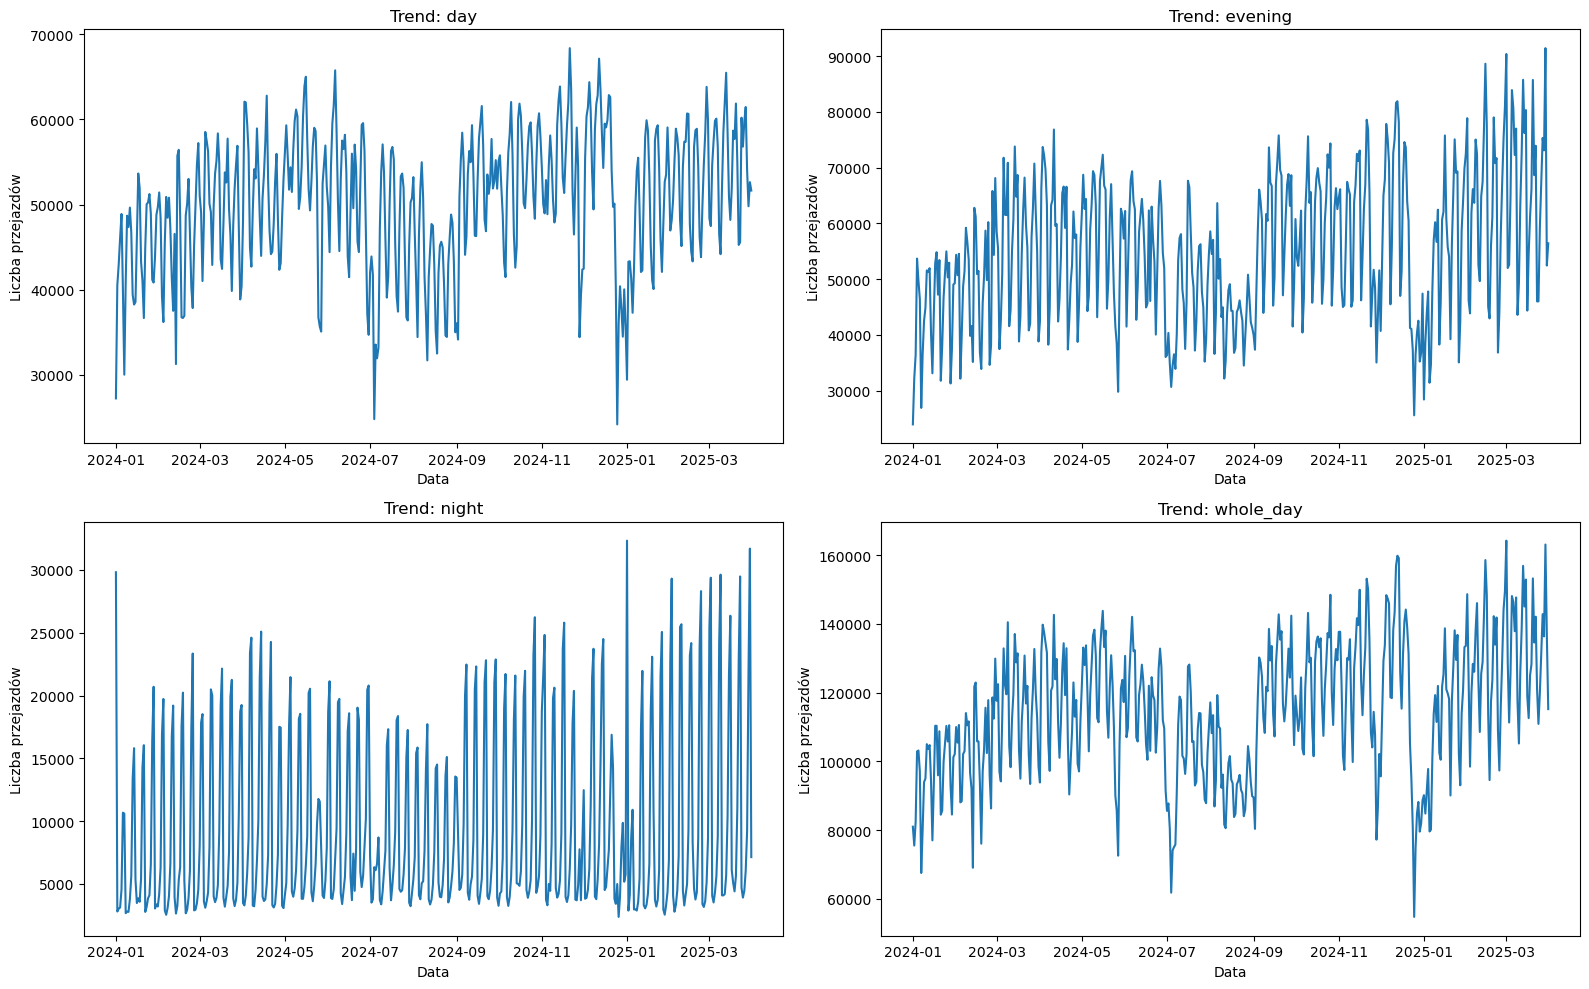

In [42]:
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
axs = axs.ravel()
dfs = [day_df, evening_df, night_df, whole_day_df]
titles = ['day', 'evening', 'night', 'whole_day']

for i, df in enumerate(dfs):
    sns.lineplot(x=df.index, y=df['rides'], ax=axs[i])
    axs[i].set_title(f"Trend: {titles[i]}")
    axs[i].set_xlabel("Data")
    axs[i].set_ylabel("Liczba przejazdów")

plt.tight_layout()
plt.show()

Wykresy mają trend wzrostowy, liczba przejazdów w ciągu roku delikatnie rosła. Okres od początku roku 2025 ukazuje dane, przy których wiele dni ma wartości bliskie maksymalnych na zbiorze. Podejrzewana jest sezonowość danych. Wykresy podobnie reagują na te same dni, tzn. np w okresie świątecznym i noworocznym można zauważyć mniejsze zapotrzebowanie.

### 2. Średnie tygodniowe oraz miesięczne

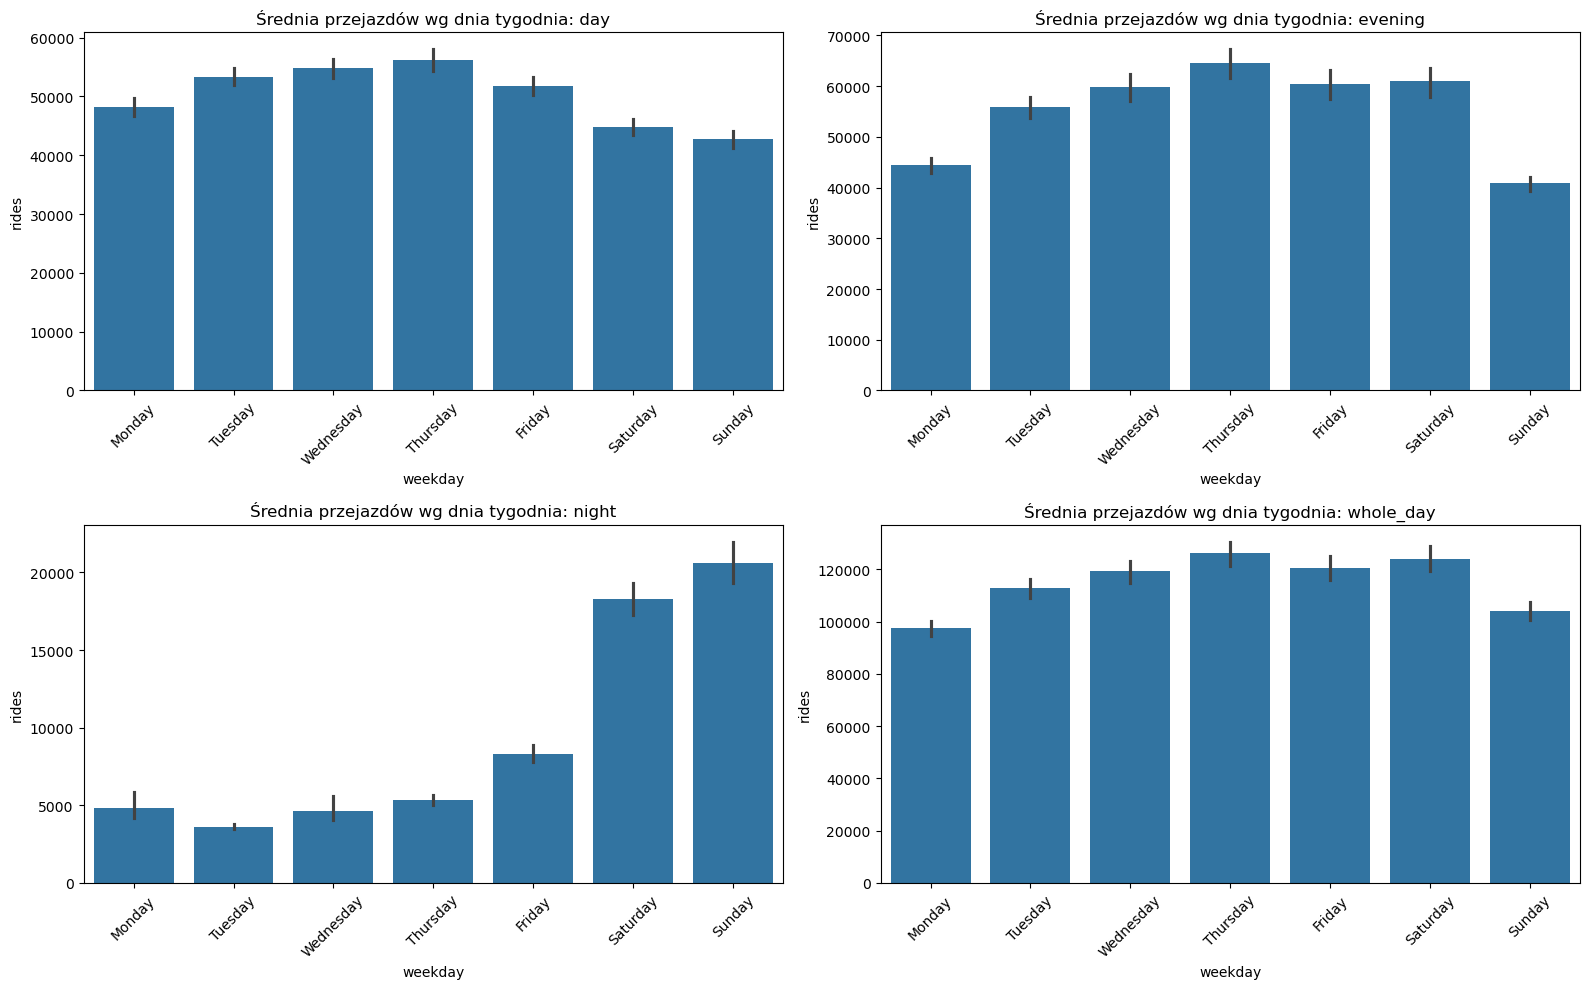

In [45]:
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
axs = axs.ravel()
dfs = [day_df, evening_df, night_df, whole_day_df]
titles = ['day', 'evening', 'night', 'whole_day']
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

for i, df in enumerate(dfs):
    df_plot = df.copy()
    df_plot['weekday'] = df_plot.index.day_name()
    sns.barplot(x='weekday', y='rides', data=df_plot, order=order, ax=axs[i])
    axs[i].set_title(f"Średnia przejazdów wg dnia tygodnia: {titles[i]}")
    axs[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Widoczne odchylenia dla średniej liczby przejazdów w weekendy w nocy. W pozostałych przypadkach liczba przejazdów jest podobna niezależnie od dnia.

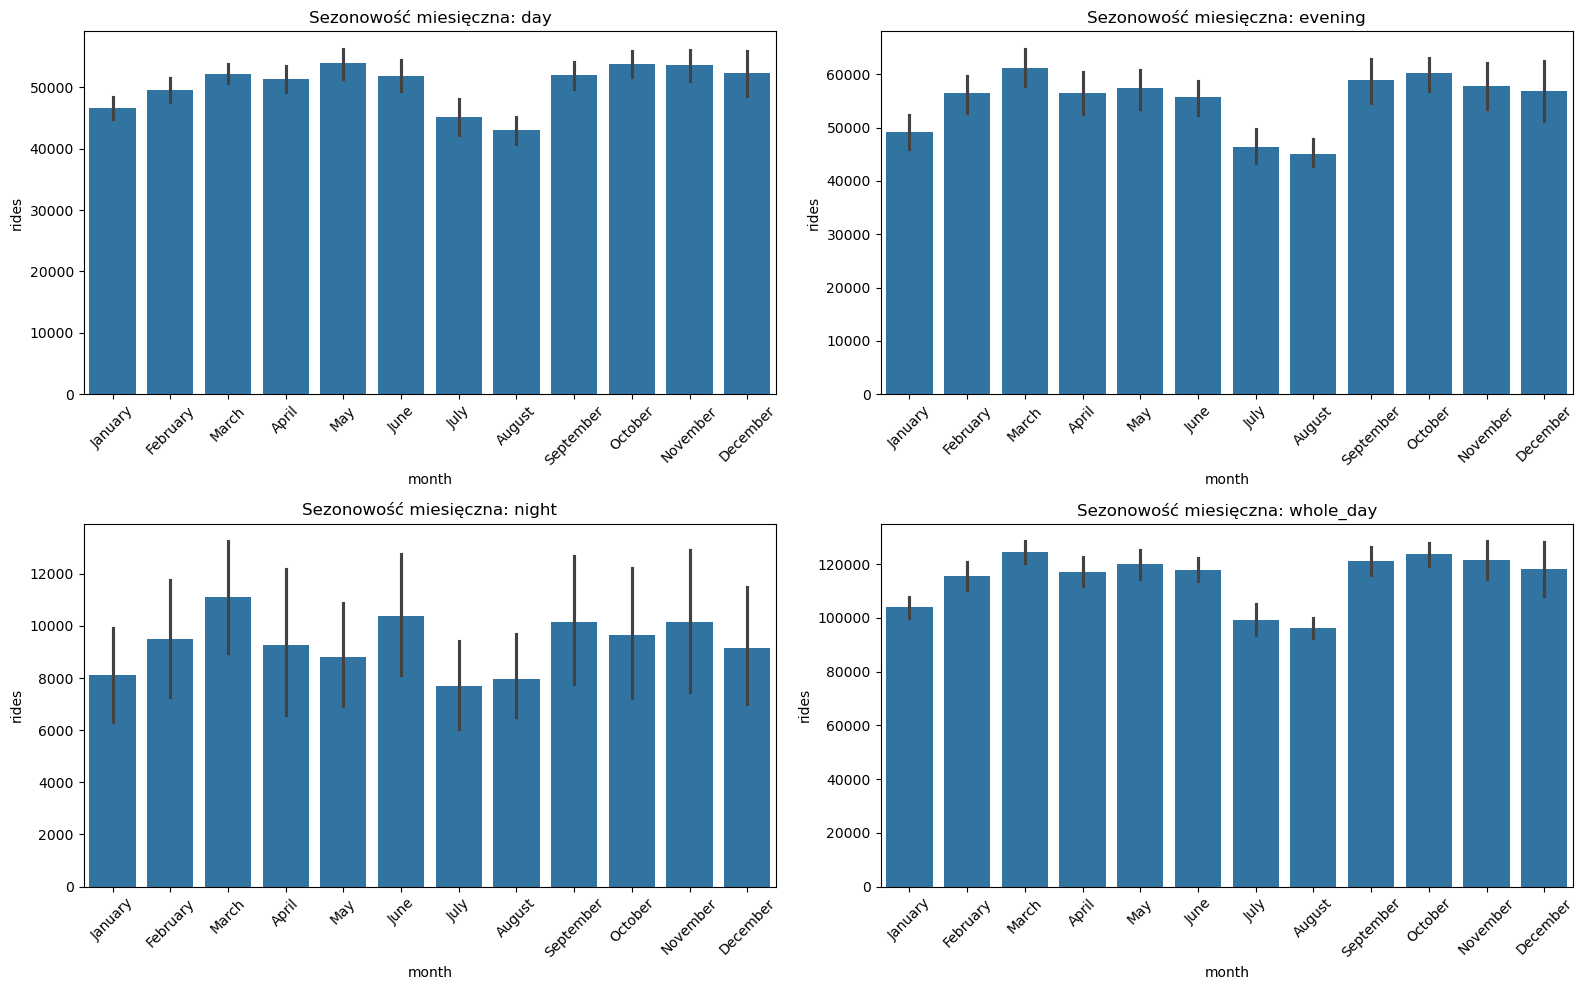

In [47]:
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
axs = axs.ravel()
dfs = [day_df, evening_df, night_df, whole_day_df]
titles = ['day', 'evening', 'night', 'whole_day']
months = ['January', 'February', 'March', 'April', 'May', 'June',
          'July', 'August', 'September', 'October', 'November', 'December']

for i, df in enumerate(dfs):
    df_plot = df.copy()
    df_plot['month'] = df_plot.index.month_name()
    sns.barplot(data=df_plot, x='month', y='rides', order=months, ax=axs[i])
    axs[i].set_title(f"Sezonowość miesięczna: {titles[i]}")
    axs[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Na każdym z wykresów widoczny spadek w miesiącach lipiec oraz sierpień. Brak widocznej sezonowości, w każdym z pozostałych miesiąców ilość przejazdów jest podobna.

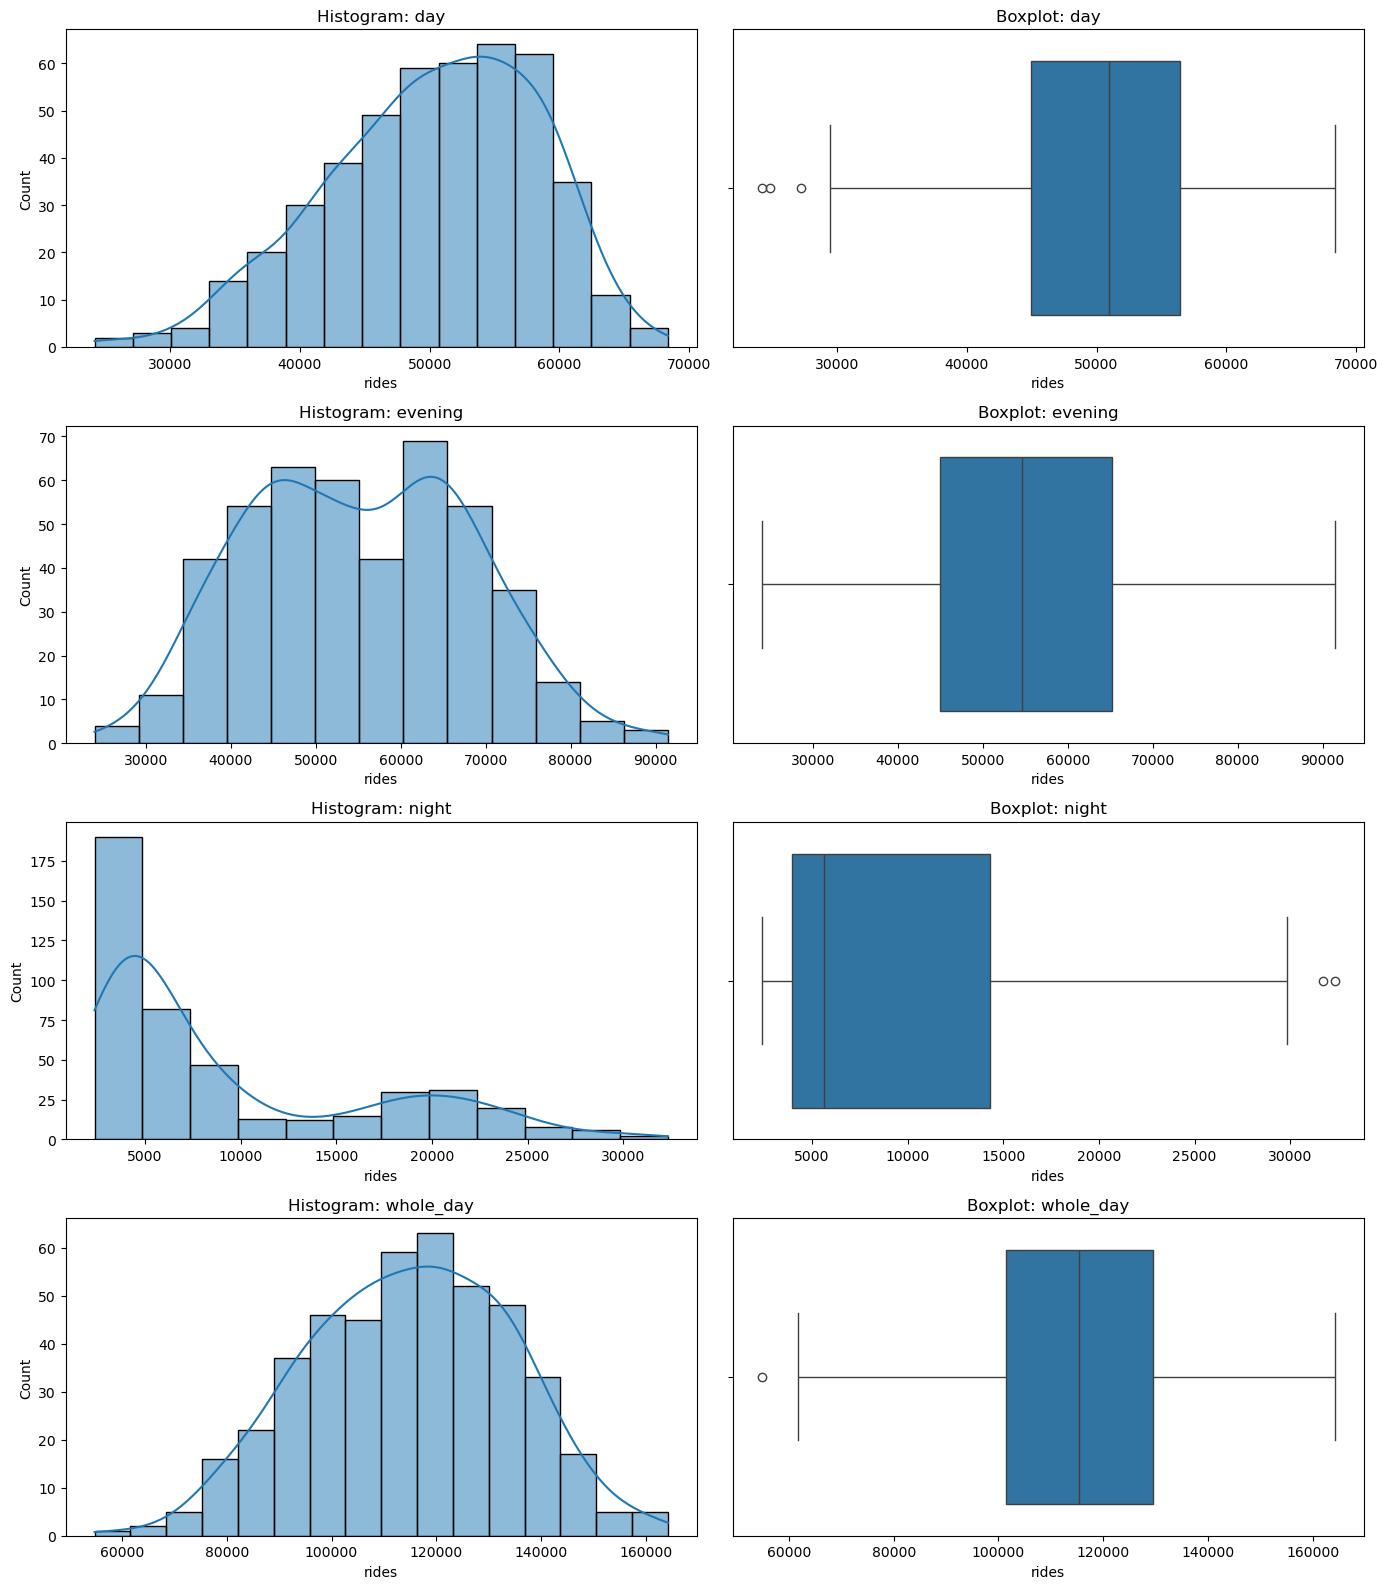

In [49]:
fig, axs = plt.subplots(4, 2, figsize=(14, 16))
titles = ['day', 'evening', 'night', 'whole_day']
dfs = [day_df, evening_df, night_df, whole_day_df]

for i, df in enumerate(dfs):
    sns.histplot(df['rides'], kde=True, ax=axs[i, 0])
    axs[i, 0].set_title(f"Histogram: {titles[i]}")
    
    sns.boxplot(x=df['rides'], ax=axs[i, 1])
    axs[i, 1].set_title(f"Boxplot: {titles[i]}")

plt.tight_layout()
plt.show()

W każdym z histogramów dane mieszczą sie w wyraźnym zakresie, maksymalna ilość danej liczby przejazdów maksymalnie jest w okolicach 70. Dane mają rozkład zbliżony do normalnego. Wyjątkiem jest histogram o porze nocnej, dane w większości znajdują sie w 5 różnych przedziałach, szczególnie dwóch pierwszych. Ma to związek z wykresami średnich tygodniowych, w ciągu tygodnia zapotrzebowanie jest mniejsze niż w weekendy. W weekendy w nocy zapotrzebowanie wzrasta praktycznie 3-krotnie w porównaniu do innych dni tygodnia.

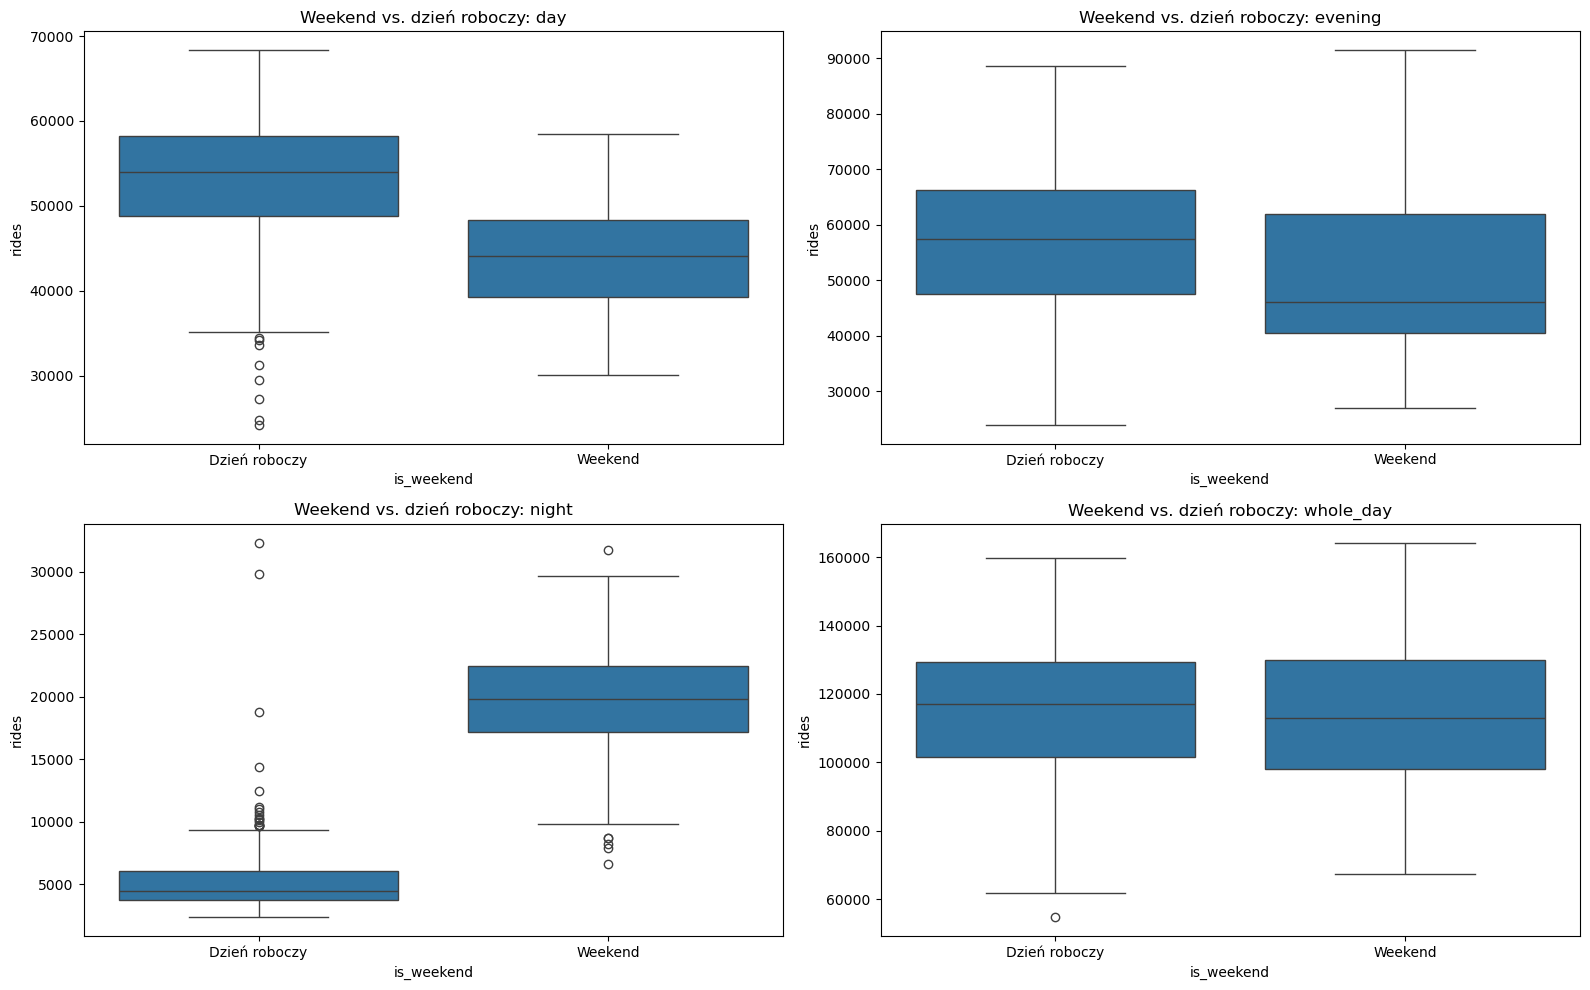

In [51]:
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
axs = axs.ravel()
dfs = [day_df, evening_df, night_df, whole_day_df]
titles = ['day', 'evening', 'night', 'whole_day']

for i, df in enumerate(dfs):
    df_plot = df.copy()
    df_plot['is_weekend'] = df_plot['is_weekend'].astype(int)
    sns.boxplot(x='is_weekend', y='rides', data=df_plot, ax=axs[i])
    axs[i].set_title(f"Weekend vs. dzień roboczy: {titles[i]}")
    axs[i].set_xticks([0, 1])
    axs[i].set_xticklabels(['Dzień roboczy', 'Weekend'])

plt.tight_layout()
plt.show()

Widzimy, że tylko dane odnośnie `night` i `day` są zależne od zmiennej `is_weekend`. W przypadku przejazdów za dnia w weekendy liczba przejazdów maleje. W nocy następuje odwrotna sytuacja, w ciągu tygodnia przejazdów jest mniej niż w weekend.

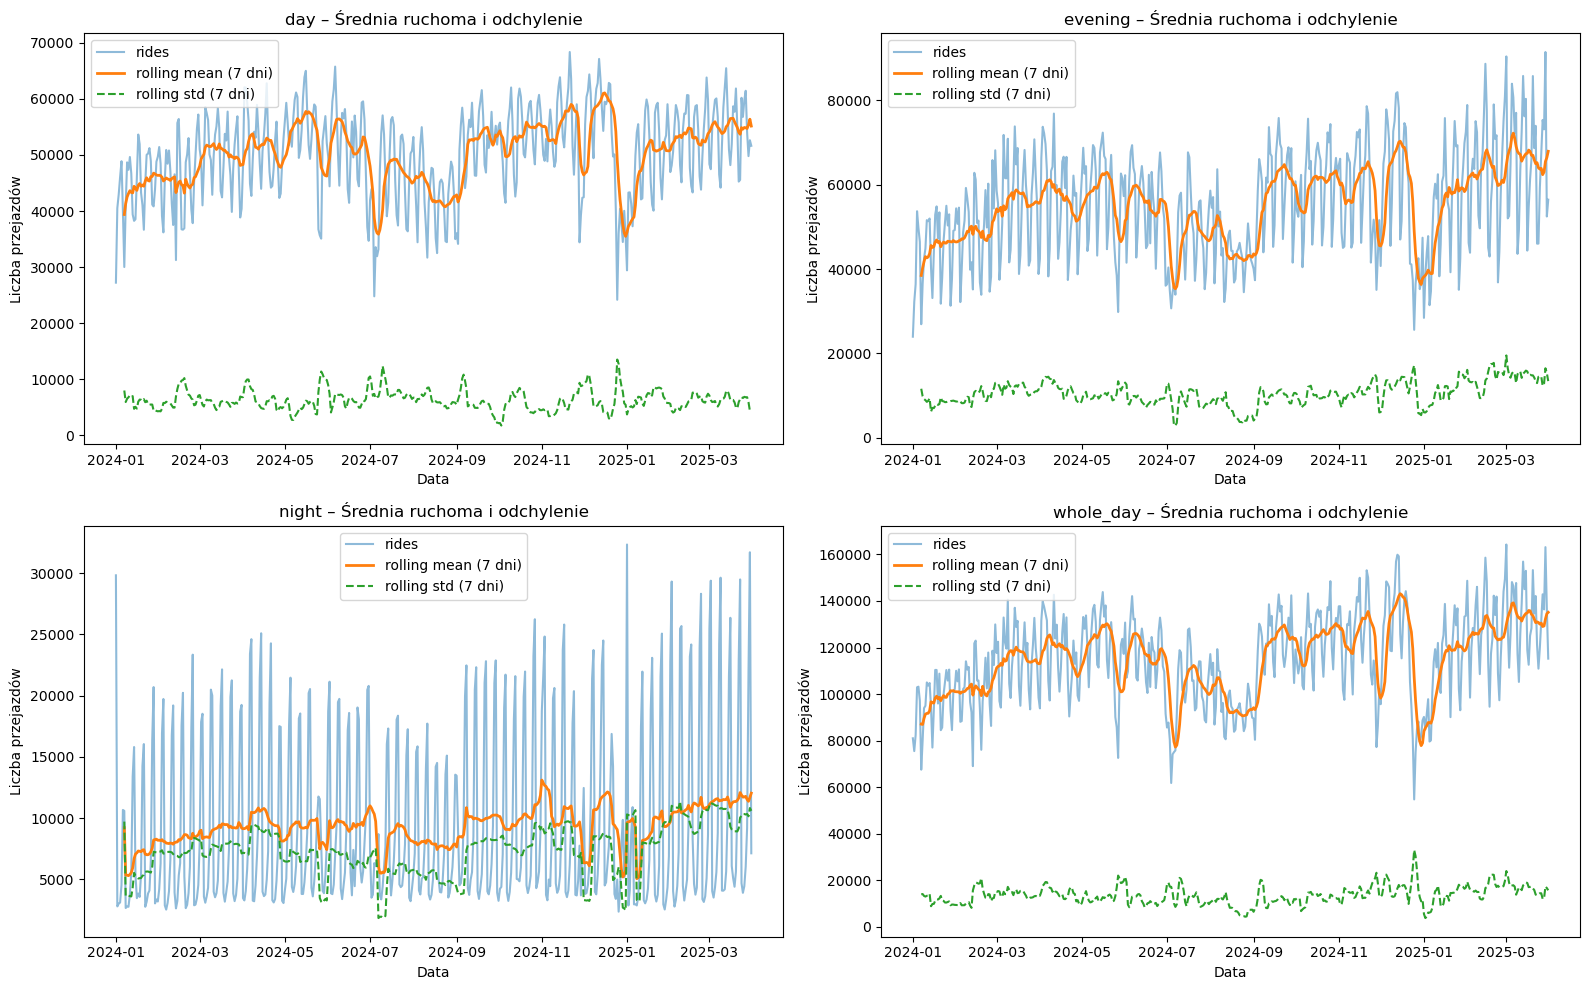

In [53]:
dfs = [day_df, evening_df, night_df, whole_day_df]
titles = ['day', 'evening', 'night', 'whole_day']
window = 7

for df in dfs:
    df['rolling_mean'] = df['rides'].rolling(window=window).mean()
    df['rolling_std'] = df['rides'].rolling(window=window).std()

# Tworzenie wykresów: 4 panele w układzie 2x2
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
axs = axs.ravel()

for i, df in enumerate(dfs):
    axs[i].plot(df.index, df['rides'], label='rides', alpha=0.5)
    axs[i].plot(df.index, df['rolling_mean'], label='rolling mean (7 dni)', linewidth=2)
    axs[i].plot(df.index, df['rolling_std'], label='rolling std (7 dni)', linestyle='--')
    axs[i].set_title(f"{titles[i]} – Średnia ruchoma i odchylenie")
    axs[i].set_xlabel("Data")
    axs[i].set_ylabel("Liczba przejazdów")
    axs[i].legend()

plt.tight_layout()
plt.show()

Średnia ruchoma jest poziomem podobna do wszystkich wykresów oprócz night. W tym przypadku widzimy widoczne skoki, co sugeruje sezonowość. Odchylenie standardowe jest zmienne, natomiast trzyma się pewnego poziomu dla każdego z okresów.

### 3. Statystyki podstawowe

In [56]:
summary_stats = pd.concat([
    day_df['rides'].describe(),
    evening_df['rides'].describe(),
    night_df['rides'].describe(),
    whole_day_df['rides'].describe()
], axis=1)

summary_stats.columns = ['day', 'evening', 'night', 'whole_day']
cv = 100 * summary_stats.loc['std'] / summary_stats.loc['mean']
summary_stats.loc['cv_%'] = cv
summary_stats.loc[['mean', '50%', 'min', 'max', 'std', 'cv_%']].round(2)

day   evening     night  whole_day
mean  50261.37  55208.25   9371.80  114841.43
50%   50949.00  54659.50   5625.50  115295.00
min   24185.00  23959.00   2372.00   54764.00
max   68358.00  91450.00  32331.00  164226.00
std    8015.46  13006.60   7327.39   19497.89
cv_%     15.95     23.56     78.19      16.98

Największe zapotrzebowanie jest w godzinach 16-24. Można też zauważyć, że przeciętnie w godzinach od 6 do 24 odbywa się 90% przejazdów. Najstabilniejsza jest liczba przejazdów od 6 do 16, w tym okresie wachanie wynosi tylko 16%.

### 4. Anomalie

In [59]:
dfs = {
    'day': day_df,
    'evening': evening_df,
    'night': night_df,
    'whole_day': whole_day_df
}


outliers_list = []


for name, df in dfs.items():
    Q1 = df['rides'].quantile(0.25)
    Q3 = df['rides'].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df['rides'] < lower) | (df['rides'] > upper)].copy()
    outliers['period'] = name
    outliers_list.append(outliers)


outliers_combined = pd.concat(outliers_list).sort_index()

In [60]:
outliers_combined[['period','rides']]

period  rides
date                        
2024-01-01        day  27237
2024-07-04        day  24802
2024-12-25        day  24185
2024-12-25  whole_day  54764
2025-01-01      night  32331
2025-03-30      night  31698

Wartości wychodzące poza trend to noc sylwestrowa, Nowy Rok, święta Bożego Narodzenia oraz Dzień Niepodległości. W przypadku danych na których przeprowadzana jest analiza ma to sens, w wyjątkowe dni w roku klienci mogą inaczej zamawiać taksówki, zmienia się zapotrzebowanie. Jedyną anomalią z dni "normalnych" jest dzień 30-03-2025. Może to wynikać z tego że dane mają wyraźny trend wzrostowy i jest to data pod koniec badanego zbioru i wartość już na tyle wzrosła, że przekracza inne normy. Istnieje też możliwość, że tego dnia było jakieś wydarzenie specjalne w mieście. Należy przyjrzeć się dokładniej temu przypadkowi.

In [62]:
check_variance_trend(night_df, "night")
check_variance_trend(whole_day_df, "whole_day")


night – Wariancje w 3 częściach danych:
  Część 1: 47198912.86
  Część 2: 40231857.61
  Część 3: 71996569.72
Wariancja wygląda na stabilną – transformacja może nie być konieczna.

whole_day – Wariancje w 3 częściach danych:
  Część 1: 283178250.87
  Część 2: 307351329.43
  Część 3: 455684788.42
Wariancja rośnie, może być potrzeba dokonania transformacji.


Przed dokonaniem modelowania uznałem, że ważne będzie też sprawdzenie wariancji, z uwagi na podejrzenie o potrzebę nałożenia logarytmu na dane.
Zbiór został podzielony na trzy części, następnie została sprawdzona wariancja w tych częściach. Dla `whole_day` jest podejrzenie użycia potrzeby użycia logarytmu. Dziwny jest przypadek z `night`. Jest duży wzrost wariancji względem innych okresów, lecz zostawiam to narazie do dalszej interpretacji.

## Podzielenie zbioru na treningowy i testowy
Zbiór został podzielony, zostały dodane zmienne egzogeniczne oraz został dodany model logarytm dla okresu `night`.

In [65]:
night_df['log_rides'] = np.log(night_df['rides'])

In [66]:
# Zakresy dat
train_start = '2024-01-01'
train_end = '2024-12-31'
test_start = '2025-01-01'
test_end = '2025-04-01'

# Lista nazw i obiektów zbiorów
datasets = {
    'day': day_df,
    'evening': evening_df,
    'night': night_df,
    'whole_day': whole_day_df
}

# Podział i zapis do zmiennych
for name, df in datasets.items():
    globals()[f'{name}_df_train'] = df.loc[train_start:train_end].copy()
    globals()[f'{name}_df_test'] = df.loc[test_start:test_end].copy()
    globals()[f'{name}_exog_train'] = df.loc[train_start:train_end][['is_weekend']].copy()
    globals()[f'{name}_exog_test'] = df.loc[test_start:test_end][['is_weekend']].copy()

# Tworzenie modelów ARIMA dla danych całodniowych
W tej sekcji zostaną stworzone modele typu ARIMA dla danych całodniowych. Po stworzeniu parametry modeli zostaną zinterpretowane i przedstawione możliwie najlepsze rozwiązanie biznesowe, jeżeli takowe będzie.

## Sprawdzanie stacjonarności szeregów

Zaczynamy od sprawdzenia stacjonarności danych, gdyż jest to warunek konieczny stworzenia modelu ARIMA.

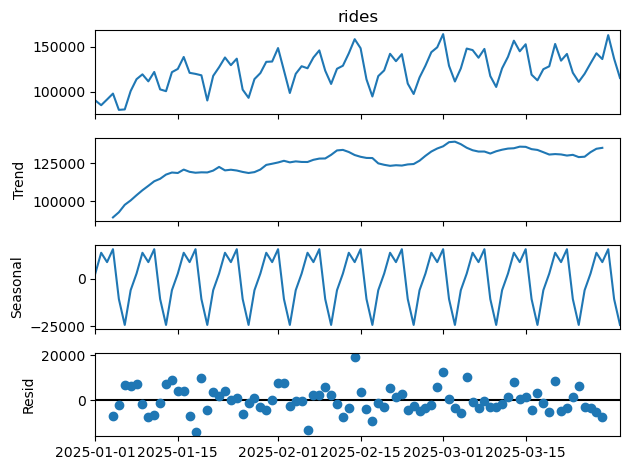

In [294]:
decomposition = seasonal_decompose(whole_day_df_test.rides, model='additive', period=7)
fig = decomposition.plot()
plt.show()

Na wykresie możemy zauważyć trend wzrostowy danych oraz ich sezonowość.

In [71]:
# test ADF (Augmented Dickey–Fuller)
adf_whole_day = adfuller(whole_day_df_train.rides)
print(f'p-value: {adf_whole_day[1]}')

p-value: 0.03537857795470724


Wartosc p-value < 0.05, wiec dane sa stacjonarne, mozemy dokonywac budowania modelu. Z uwagi na podejrzenie sezonowości musimy także dokonąc testu ADF dla danych po przesunięciu sezonowym.

In [73]:
# test ADF (Augmented Dickey–Fuller) dla sezonowosci
seasonal_diff = whole_day_df_train.rides - whole_day_df_train.rides.shift(7)
seasonal_diff = seasonal_diff.dropna()
adf_whole_day_season = adfuller(seasonal_diff)
print(f'p-value: {adf_whole_day_season[1]}')

p-value: 3.983746471600865e-07


Roznicowanie sezonowe zwraca p-value > 0.05, wiec zostawiamy D=0 dla modeli.

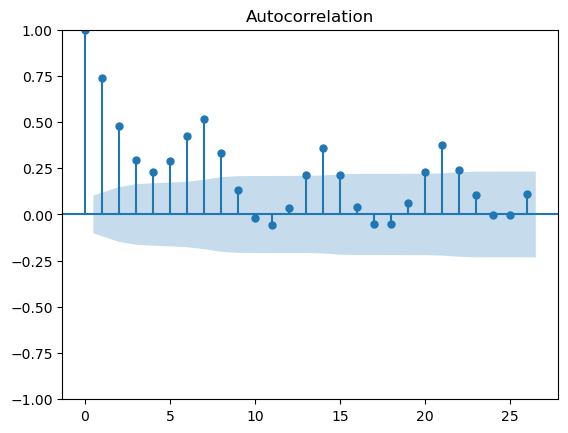

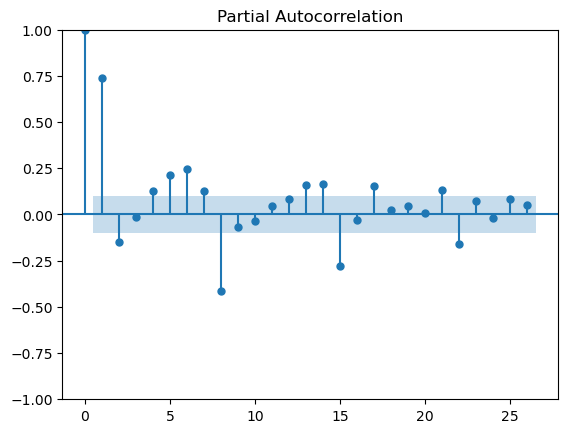

In [75]:
# wykresy ACF i PACF
acf_whole_day = plot_acf(whole_day_df_train.rides)
pacf_whole_day = plot_pacf(whole_day_df_train.rides)

In [76]:
df_base = pd.concat([whole_day_df_train, whole_day_df_test]).copy()

## Fitowanie modelu ARIMA
Dla tego modelu opisane beda wartosci testów (nie ma sensu powielania tego samego dla wszystkich modeli, testy są te same).

In [78]:
forecast_wd_arima, model_wd_arima = train_arima(whole_day_df_train.rides, whole_day_df_test.rides, order=(1,0,3))
print(model_wd_arima.summary())

C:\Users\krack\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\krack\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\krack\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  rides   No. Observations:                  366
Model:                 ARIMA(1, 0, 3)   Log Likelihood               -3966.135
Date:                Sat, 14 Jun 2025   AIC                           7944.270
Time:                        11:46:28   BIC                           7967.686
Sample:                    01-01-2024   HQIC                          7953.575
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.125e+05   4094.004     27.476      0.000    1.04e+05    1.21e+05
ar.L1          0.9417      0.036     26.441      0.000       0.872       1.011
ma.L1         -0.1304      0.063     -2.054      0.0

Model przeszedł wszystkie testy.
Test Ljung-Box sprawdza rozkład losowy reszt, p>0.05 oznacza że rozkład jest losowy.
Test JB sprawdza rozkład reszt, czy jest zbliżony do normalnego, p > 0.05 oznacza że jest.
Test na heteroskedastyczność (miara stałej wariancji), p >0.05, reszty mają stały rorzut co oznacza homoskedastyczność.

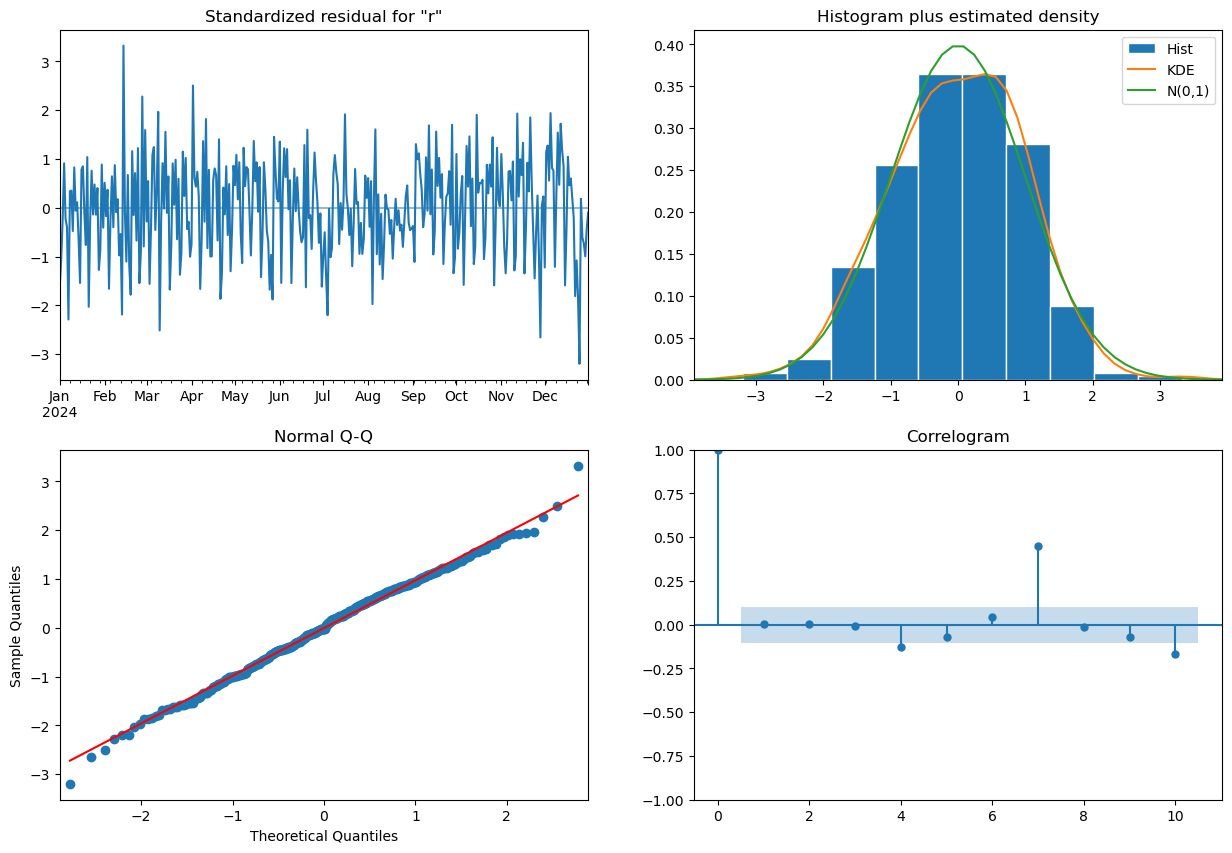

In [80]:
model_wd_arima.plot_diagnostics(figsize=(15, 10))
plt.show()

Testy mają swoje potwierdzenie również na wykresach.

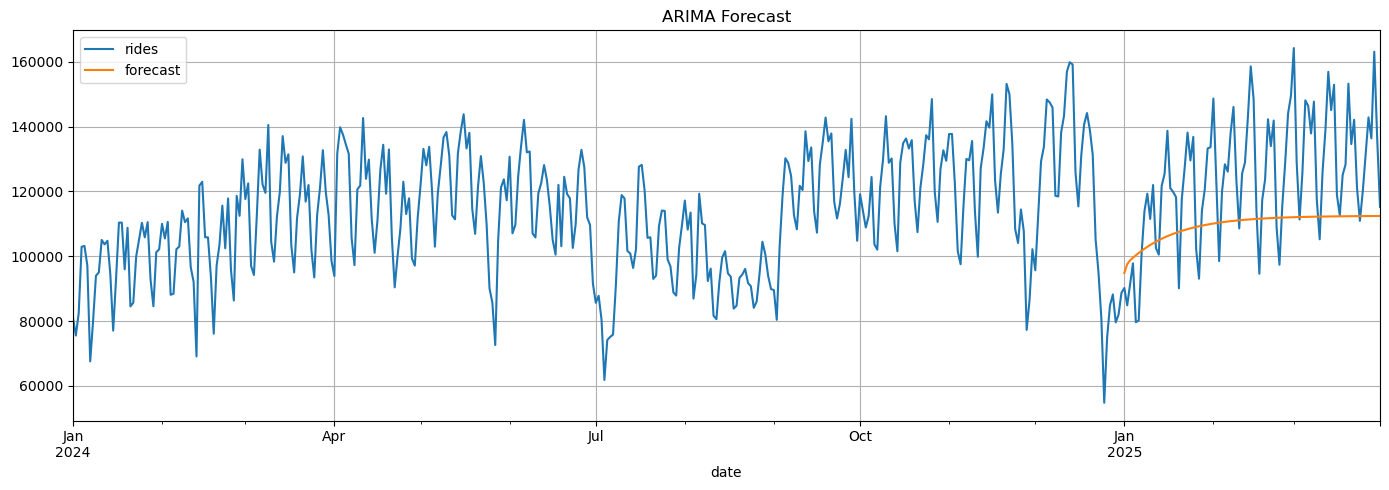

In [82]:
df_arima = plot_forecast(df_base, forecast_wd_arima, len(whole_day_df_train), title='ARIMA Forecast')

In [83]:
evaluate_forecast(whole_day_df_test.rides, forecast_wd_arima, False)

{'mae': 18772.356492957228, 'mape': 0.14301185628781693}

## Fitowanie modelu SARIMA

In [85]:
forecast_wd_sarima, model_wd_sarima = train_sarima(whole_day_df_train.rides, whole_day_df_test.rides, order=(1,0,1), seasonal_order=(1,0,1,7))
print(model_wd_sarima.summary())

C:\Users\krack\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\krack\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                             rides   No. Observations:                  366
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood               -3860.197
Date:                           Sat, 14 Jun 2025   AIC                           7730.394
Time:                                   11:46:30   BIC                           7749.908
Sample:                               01-01-2024   HQIC                          7738.148
                                    - 12-31-2024                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8766      0.033     26.272      0.000       0.811       0.942
ma.L1         -0.0239      0.049     -0.490

C:\Users\krack\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


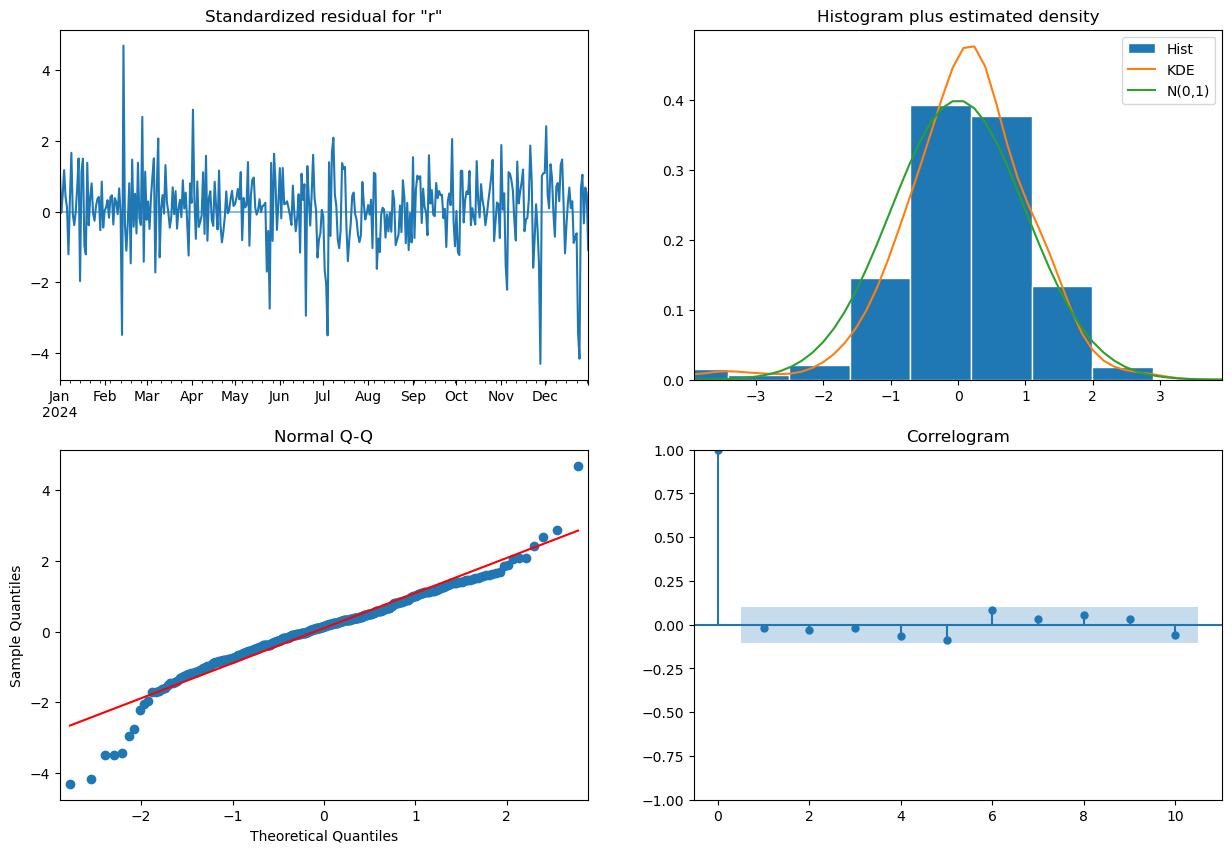

In [87]:
model_wd_sarima.plot_diagnostics(figsize=(15, 10))
plt.show()

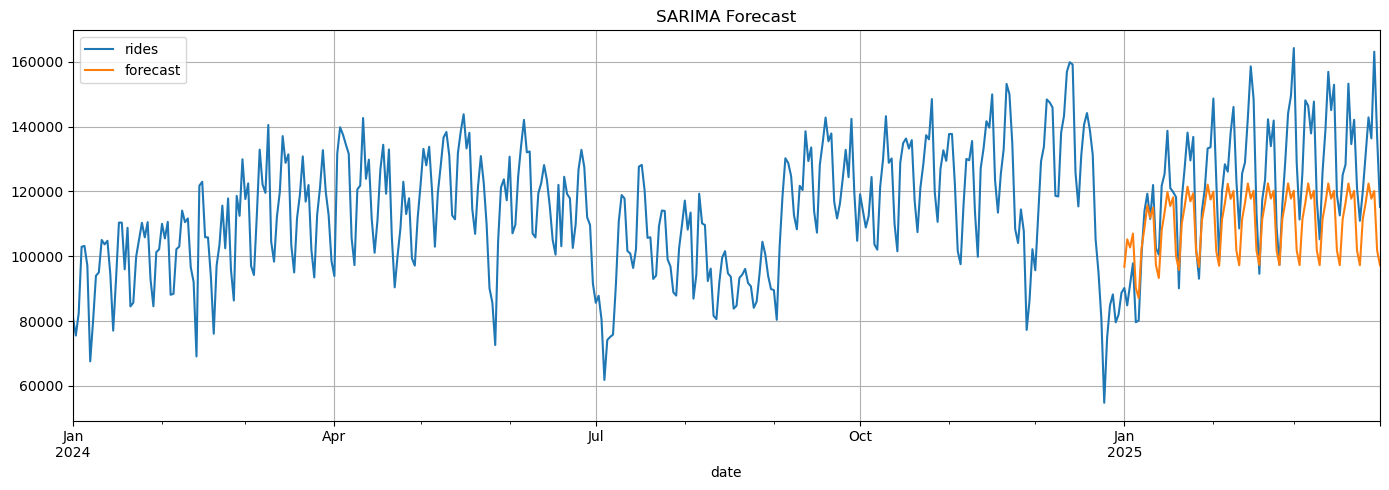

In [88]:
df_sarima = plot_forecast(df_base, forecast_wd_sarima, len(whole_day_df_train), title='SARIMA Forecast')

In [89]:
evaluate_forecast(whole_day_df_test.rides, forecast_wd_sarima, False)

{'mae': 15435.618602607272, 'mape': 0.11780086537504607}

## Fit modelu SARIMAX

In [91]:
forecast_wd_sarimax, model_wd_sarimax = train_sarimax(whole_day_df_train.rides, whole_day_df_test.rides, whole_day_exog_train, whole_day_exog_test, order=(1,0,2), seasonal_order=(1,0,1,7))
print(model_wd_sarimax.summary())

C:\Users\krack\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\krack\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                               rides   No. Observations:                  366
Model:             SARIMAX(1, 0, 2)x(1, 0, [1], 7)   Log Likelihood               -3970.877
Date:                             Sat, 14 Jun 2025   AIC                           7955.755
Time:                                     11:46:32   BIC                           7983.073
Sample:                                 01-01-2024   HQIC                          7966.610
                                      - 12-31-2024                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
is_weekend  1.104e+05   1.72e-10   6.44e+14      0.000     1.1e+05     1.1e+05
ar.L1          1.0000      

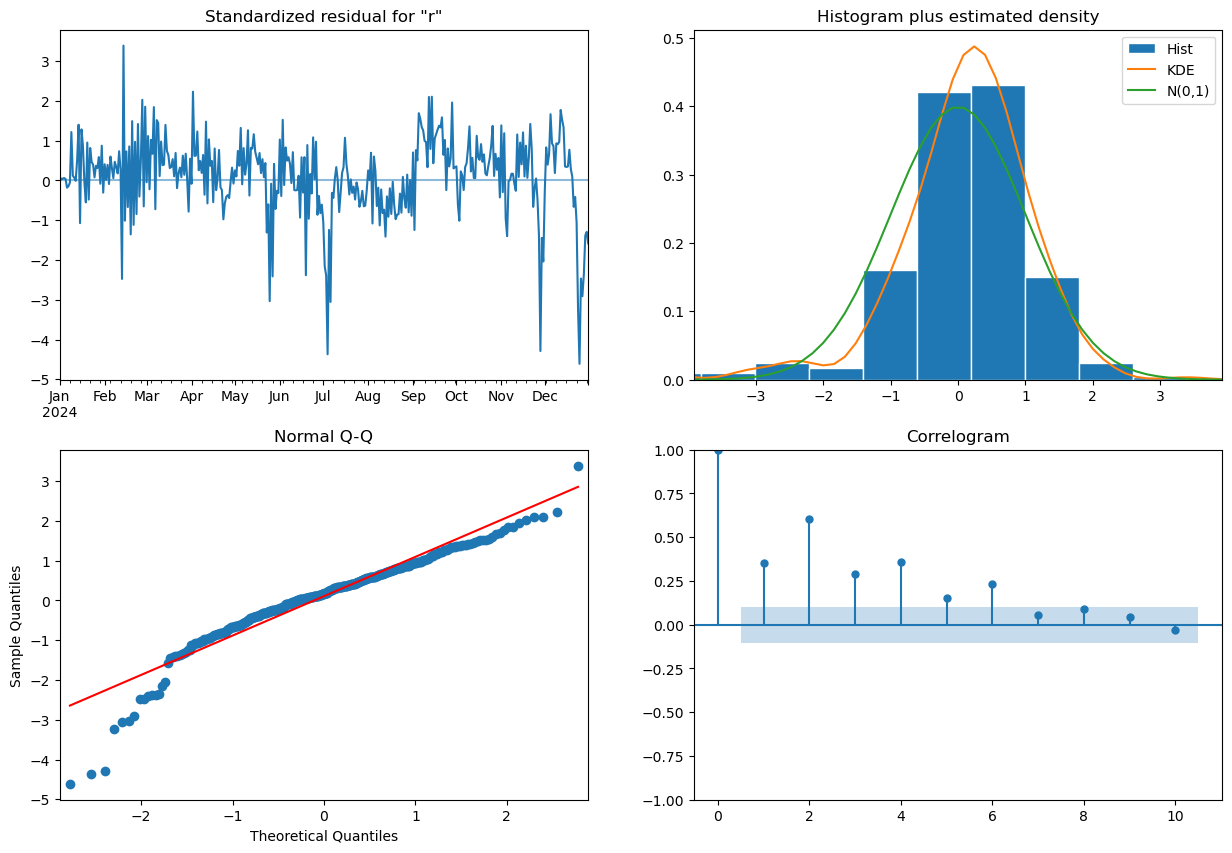

In [92]:
model_wd_sarimax.plot_diagnostics(figsize=(15, 10))
plt.show()

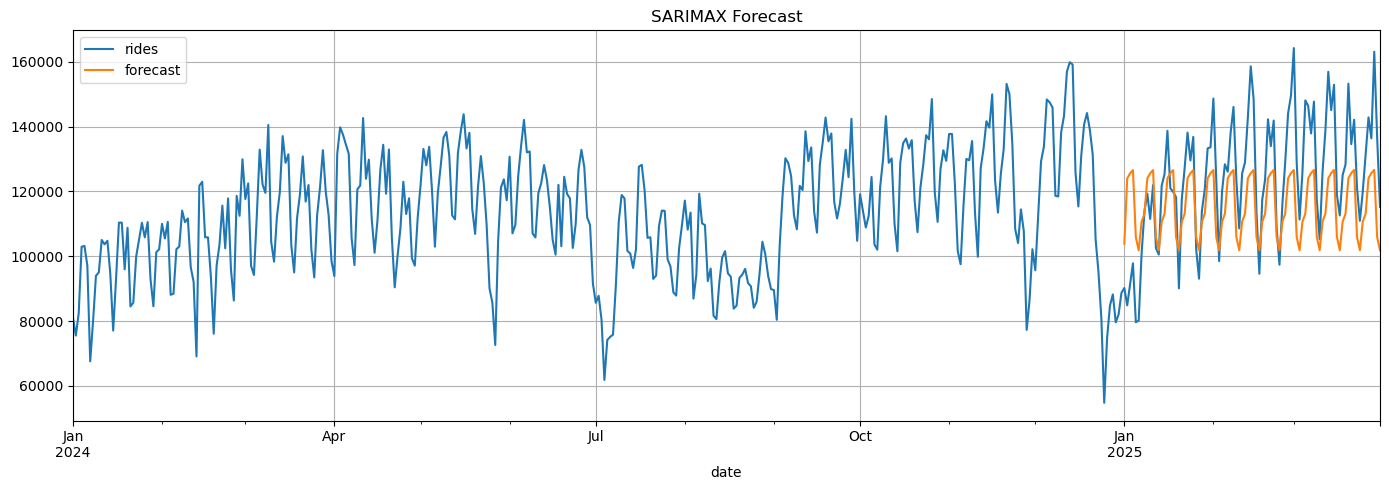

In [93]:
df_sarimax = plot_forecast(df_base, forecast_wd_sarimax, len(whole_day_df_train), title='SARIMAX Forecast')

In [94]:
evaluate_forecast(whole_day_df_test.rides, forecast_wd_sarimax, False)

{'mae': 14697.174255020298, 'mape': 0.11782170741896021}

## Fit modelu AUTOARIMA

In [301]:
model_wd_autoarima = auto_arima(
    whole_day_df_train.rides,
    seasonal=False,       
    stepwise=False        
)


print(model_wd_autoarima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  366
Model:               SARIMAX(2, 1, 3)   Log Likelihood               -3913.821
Date:                Sat, 14 Jun 2025   AIC                           7841.642
Time:                        12:42:03   BIC                           7868.941
Sample:                    01-01-2024   HQIC                          7852.491
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -58.2302    283.524     -0.205      0.837    -613.927     497.467
ar.L1          1.2335      0.011    113.736      0.000       1.212       1.255
ar.L2         -0.9833      0.010   -102.076      0.0

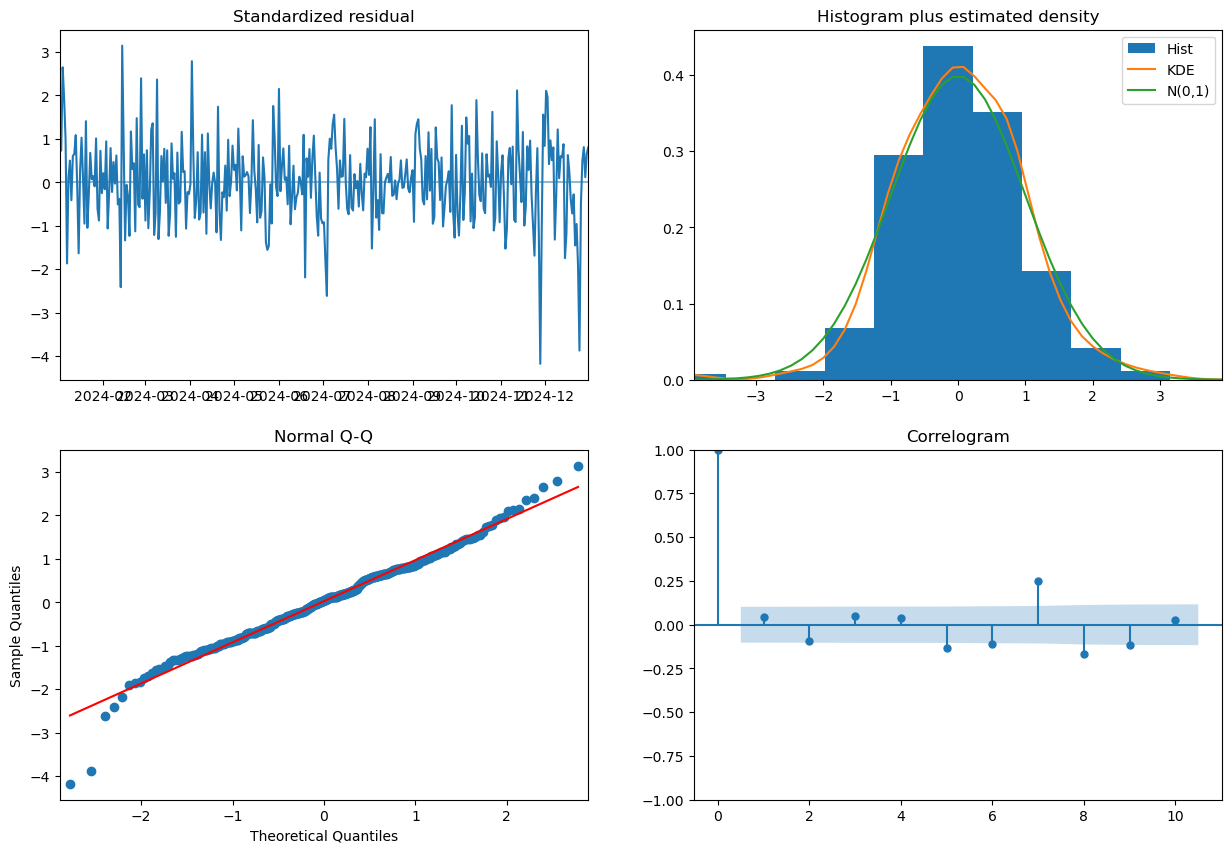

In [97]:
model_wd_autoarima.plot_diagnostics(figsize=(15, 10))
plt.show()

In [98]:
forecast_wd_autoarima = model_wd_autoarima.predict(len(whole_day_df_test.rides))


<Axes: xlabel='date'>

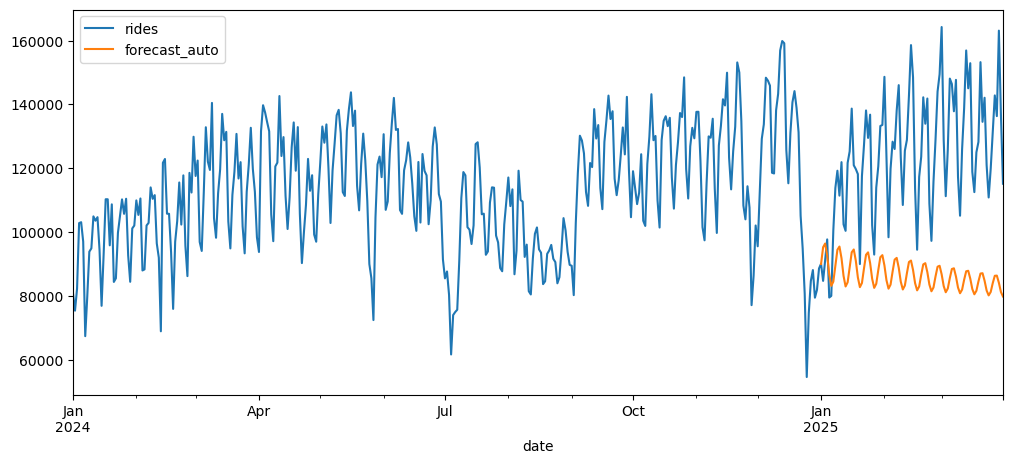

In [99]:
df_autoarima = df_base.copy()
df_autoarima['forecast_auto'] = [None]*len(whole_day_df_train.rides) + list(forecast_wd_autoarima)
df_autoarima[['rides', 'forecast_auto']].plot(figsize=(12, 5))

In [100]:
evaluate_forecast(whole_day_df_test.rides, forecast_wd_autoarima, False)

{'mae': 38301.14777815368, 'mape': 0.2929503747923403}

## Fit modelu AUTOARIMA z sezonowością

In [102]:
model_wd_autosarima = auto_arima(
    whole_day_df_train.rides,
    seasonal=True,
    m=7,
    stepwise=False    
)


print(model_wd_autosarima.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  366
Model:             SARIMAX(1, 1, 0)x(1, 0, [1], 7)   Log Likelihood               -3872.059
Date:                             Sat, 14 Jun 2025   AIC                           7754.117
Time:                                     11:47:20   BIC                           7773.617
Sample:                                 01-01-2024   HQIC                          7761.866
                                      - 12-31-2024                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.5847     73.628      0.035      0.972    -141.723     146.893
ar.L1         -0.1462      

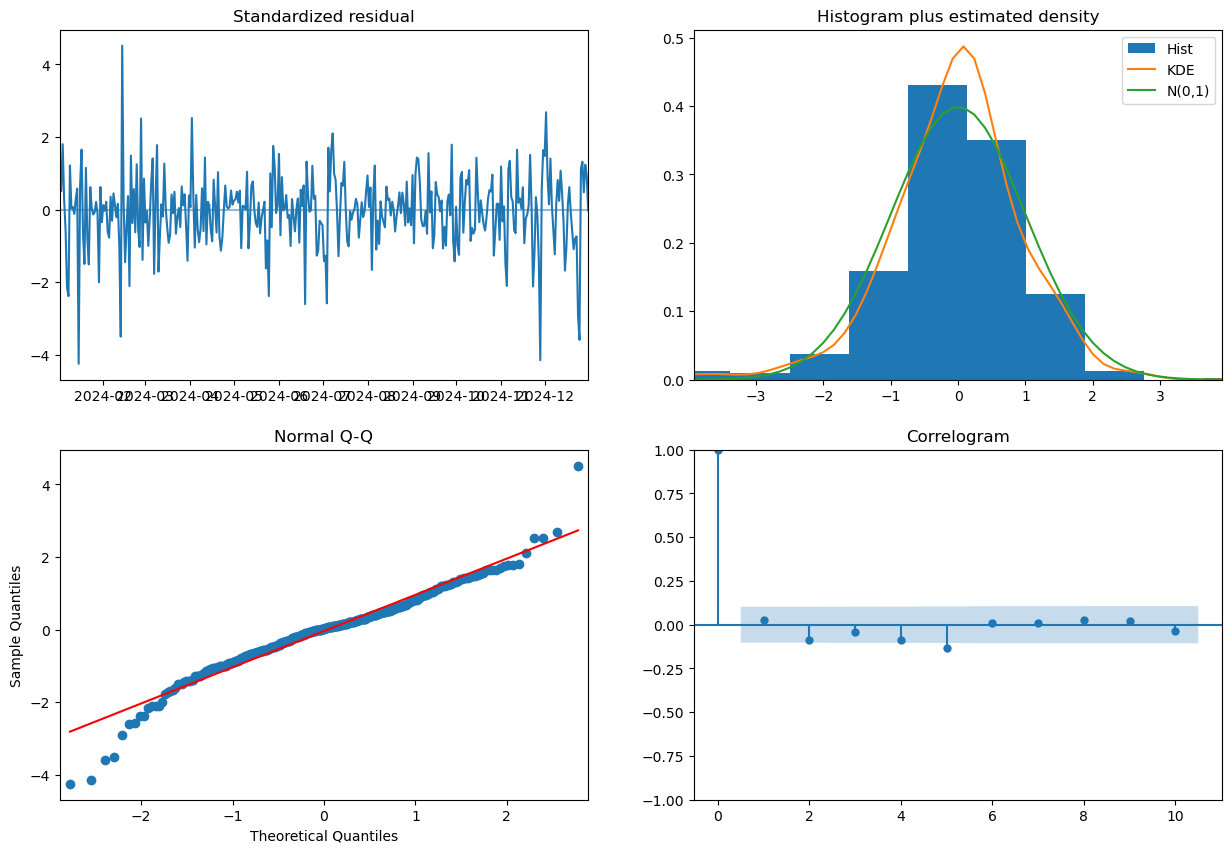

In [103]:
model_wd_autosarima.plot_diagnostics(figsize=(15, 10))
plt.show()

In [104]:
forecast_wd_autosarima = model_wd_autosarima.predict(len(whole_day_df_test.rides))


<Axes: xlabel='date'>

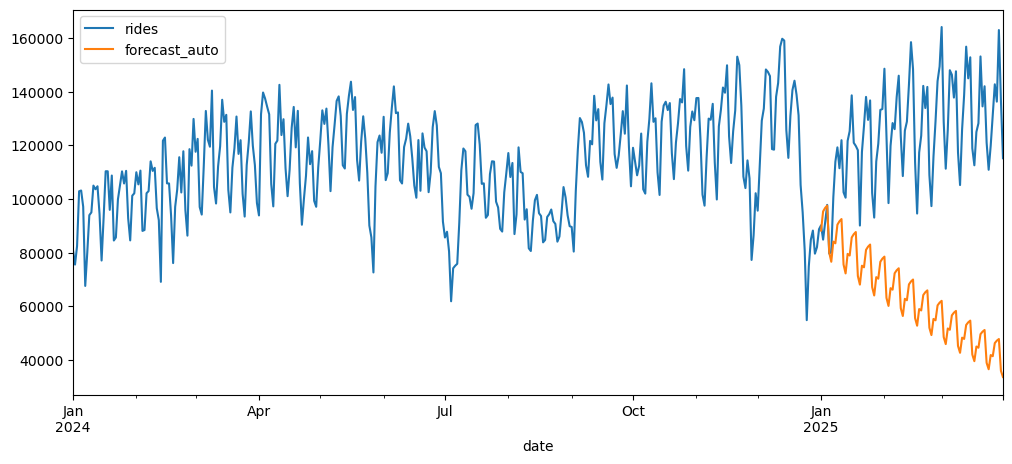

In [105]:
df_autosarima = df_base.copy()
df_autosarima['forecast_auto'] = [None]*len(whole_day_df_train.rides) + list(forecast_wd_autosarima)
df_autosarima[['rides', 'forecast_auto']].plot(figsize=(12, 5))

In [106]:
evaluate_forecast(whole_day_df_test.rides, forecast_wd_autosarima, False)


{'mae': 61153.75386275518, 'mape': 0.4734370775336629}

# Porównanie modeli ARIMA stworzonych dla zmiennej `whole_day`

In [303]:
stats_wd_arima      = evaluate_forecast(whole_day_df_test.rides, forecast_wd_arima, False)
stats_wd_sarima     = evaluate_forecast(whole_day_df_test.rides, forecast_wd_sarima, False)
stats_wd_sarimax    = evaluate_forecast(whole_day_df_test.rides, forecast_wd_sarimax, False)
stats_wd_autoarima = evaluate_forecast(whole_day_df_test.rides, forecast_wd_autoarima, False)
stats_wd_autosarima    = evaluate_forecast(whole_day_df_test.rides, forecast_wd_autosarima, False)

# Zbieramy je do jednej listy
all_stats = [
    {'model': 'ARIMA',      **stats_wd_arima},
    {'model': 'SARIMA',     **stats_wd_sarima},
    {'model': 'autoARIMA',  **stats_wd_autoarima},
    {'model': 'SARIMAX',    **stats_wd_sarimax},
    {'model': 'autoSARIMA',    **stats_wd_autosarima}
]

# Tworzymy DataFrame
comparison_df = pd.DataFrame(all_stats)

comparison_df = comparison_df.sort_values(by='mae')
comparison_df

model           mae      mape
3     SARIMAX  14697.174255  0.117822
1      SARIMA  15435.618603  0.117801
0       ARIMA  18772.356493  0.143012
2   autoARIMA  38301.147778  0.292950
4  autoSARIMA  61153.753863  0.473437

Najlepszy wynik predykcji osiągnął model SARIMAX, uzyskując najniższy błąd bezwzględny (MAE ≈ 14,7 tys.) i procentowy (MAPE ≈ 11,8%). Bardzo podobną skuteczność miał model SARIMA (MAE ≈ 15,4 tys.), co potwierdza, że modelowanie sezonowości tygodniowej znacząco poprawia jakość prognoz. Klasyczny model ARIMA (bez sezonowości) wypadł wyraźnie gorzej (MAPE ≈ 14,3%), a modele automatyczne (autoARIMA, autoSARIMA) były najmniej trafne i nie powinny być wykorzystywane w tym przypadku. Rekomendowane jest stosowanie modelu SARIMAX lub SARIMA, ponieważ najlepiej odzwierciedlają rzeczywiste wzorce i zapewniają najniższy błąd prognozowania.

# Tworzenie modelów ARIMA dla zmiennej `night`

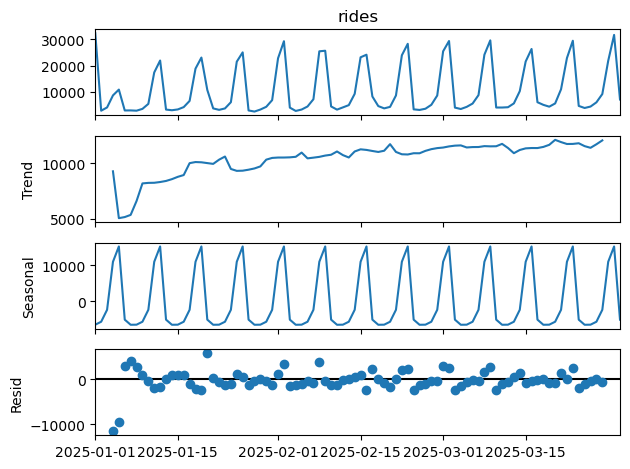

In [307]:
decomposition = seasonal_decompose(night_df_test.rides, model='additive', period=7)
fig = decomposition.plot()
plt.show()

In [112]:
# test ADF (Augmented Dickey–Fuller)
adf_night = adfuller(night_df_train.rides)
print(f'p-value: {adf_night[1]}')

p-value: 0.0007860830957284329


Wartosc p-value < 0.05, dane sa stacjonarne. Parametr d=0.



In [114]:
# test ADF (Augmented Dickey–Fuller) dla sezonowosci
seasonal_diff = night_df_train.rides - night_df_train.rides.shift(7)
seasonal_diff = seasonal_diff.dropna()
adf_night_season = adfuller(seasonal_diff)
print(f'p-value: {adf_night_season[1]}')

p-value: 1.1932157485511432e-10


Test ADF wykonany na sezonowo zróżnicowanej serii (różnicowanie co 7 dni) daje p-value < 0.05, co oznacza, że po jednym sezonowym różnicowaniu szereg jest stacjonarny. W modelu SARIMA należy przyjąć parametr D=1.

In [116]:
df_night_base = pd.concat([night_df_train, night_df_test]).copy()


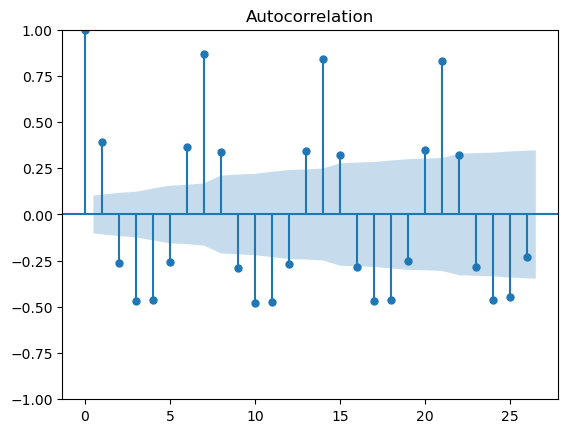

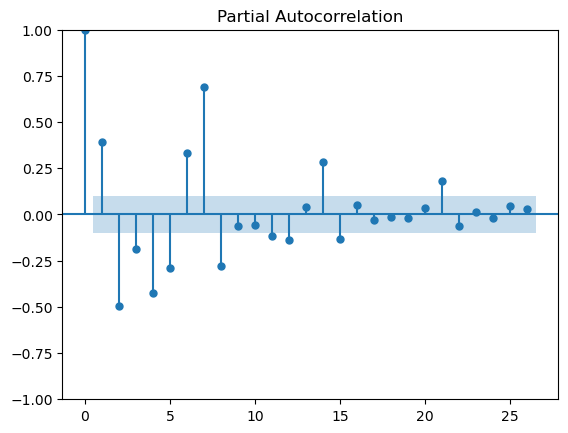

In [117]:
# wykresy ACF i PACF dla d=0
acf_night = plot_acf(night_df_train.rides)
pacf_night = plot_pacf(night_df_train.rides)

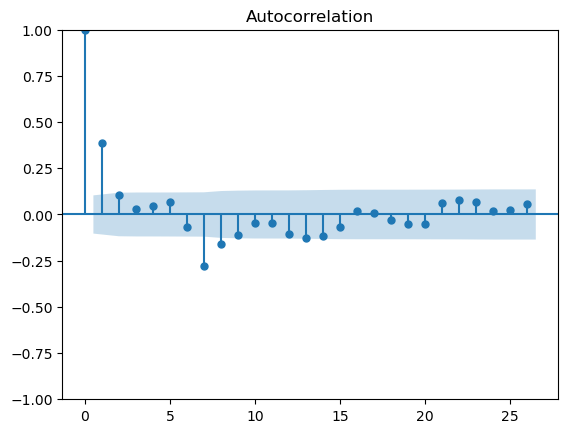

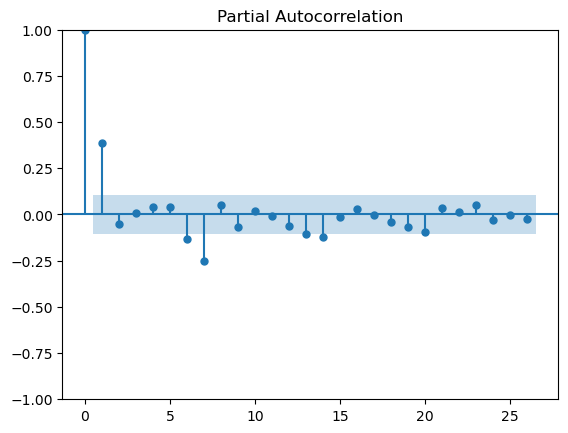

In [118]:
# wykresy ACF i PACF dla D=1
acf_night = plot_acf(seasonal_diff)
pacf_night = plot_pacf(seasonal_diff)

## Fitowanie modelu ARIMA

In [120]:
forecast_night_arima, model_night_arima = train_arima(night_df_train.rides, night_df_test.rides, order=(2,0,2))
print(model_night_arima.summary())

C:\Users\krack\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\krack\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\krack\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  rides   No. Observations:                  366
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -3572.349
Date:                Sat, 14 Jun 2025   AIC                           7156.699
Time:                        11:47:23   BIC                           7180.114
Sample:                    01-01-2024   HQIC                          7166.003
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9047.2009    319.811     28.289      0.000    8420.384    9674.018
ar.L1          1.2460      0.002    707.710      0.000       1.243       1.249
ar.L2         -0.9997      0.001  -1512.613      0.0

C:\Users\krack\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


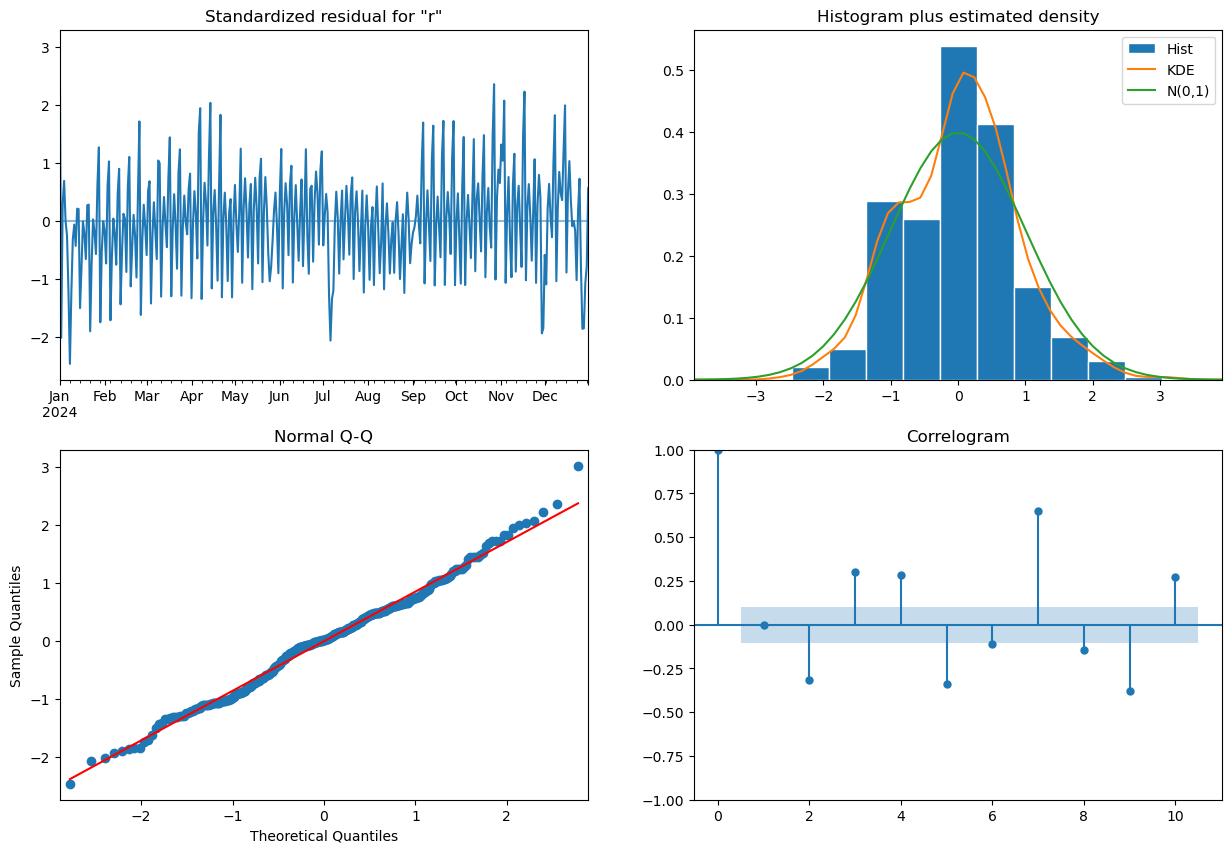

In [121]:
model_night_arima.plot_diagnostics(figsize=(15, 10))
plt.show()

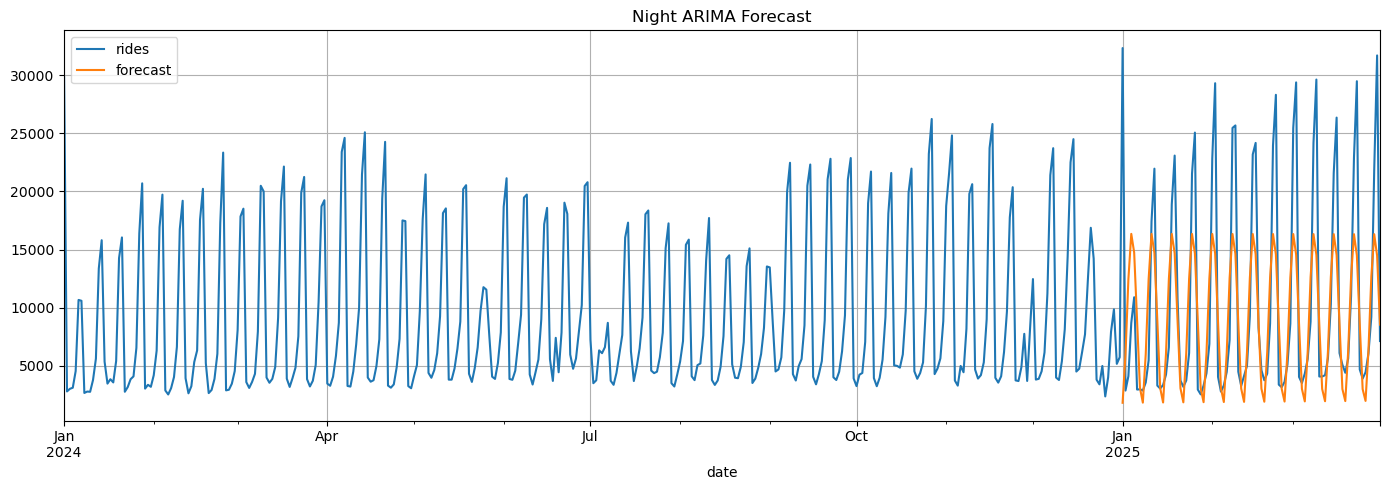

In [122]:
df_night_arima = plot_forecast(df_night_base, forecast_night_arima, len(night_df_train), title='Night ARIMA Forecast')


In [123]:
evaluate_forecast(night_df_test.rides, forecast_night_arima, False)


{'mae': 4723.594602955733, 'mape': 0.5090499342682205}

## Fitowanie modelu SARIMA

In [125]:
forecast_night_sarima, model_night_sarima = train_sarima(night_df_train.rides, night_df_test.rides, order=(2,0,2), seasonal_order=(1,1,1,7))
print(model_night_sarima.summary())

C:\Users\krack\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\krack\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                               rides   No. Observations:                  366
Model:             SARIMAX(2, 0, 2)x(1, 1, [1], 7)   Log Likelihood               -3324.925
Date:                             Sat, 14 Jun 2025   AIC                           6663.850
Time:                                     11:47:24   BIC                           6691.033
Sample:                                 01-01-2024   HQIC                          6674.660
                                      - 12-31-2024                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0484      0.213      4.928      0.000       0.631       1.465
ar.L2         -0.0663      

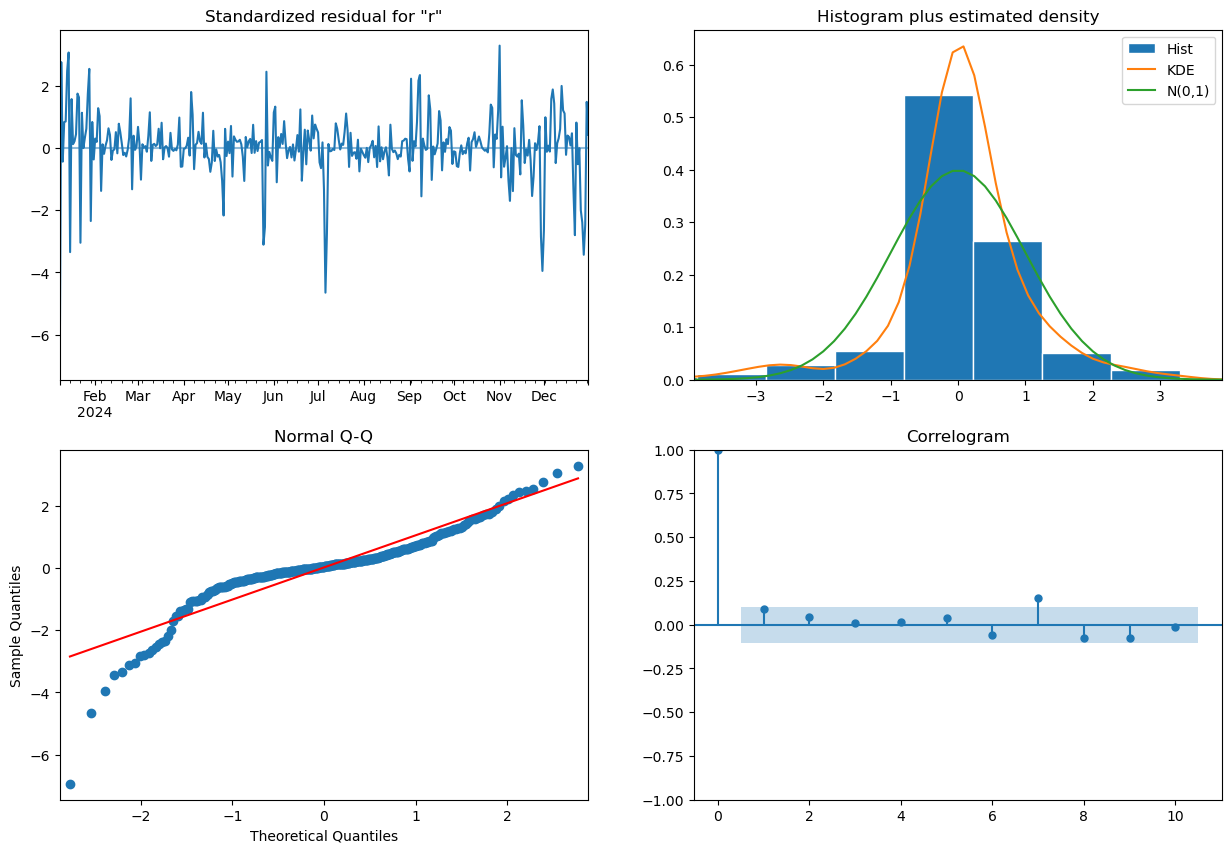

In [126]:
model_night_sarima.plot_diagnostics(figsize=(15, 10))
plt.show()

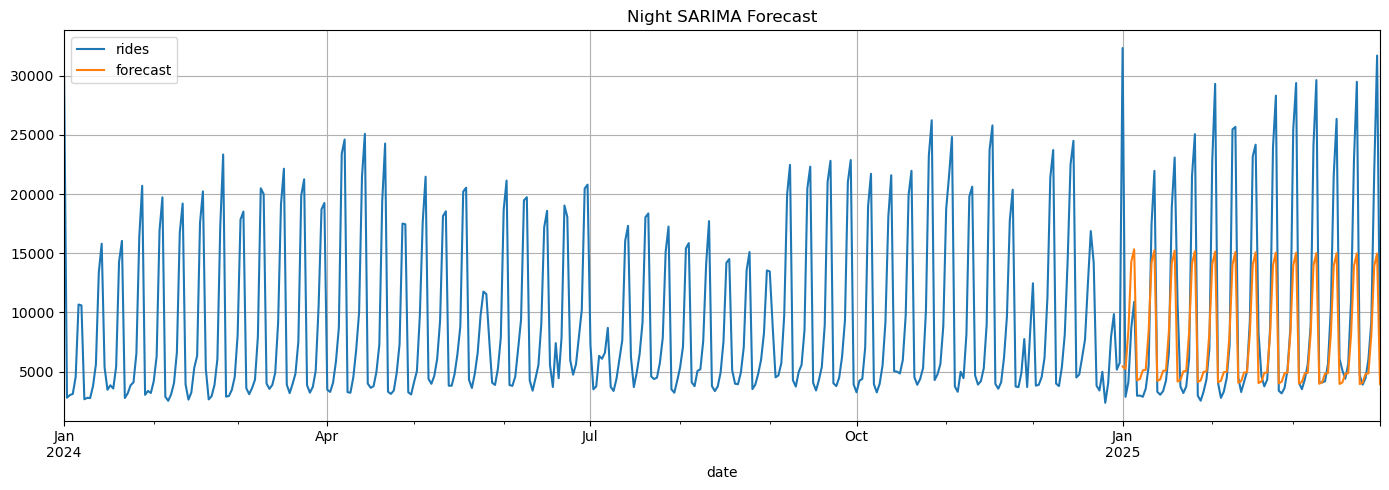

In [127]:
df_night_sarima = plot_forecast(df_night_base, forecast_night_sarima, len(night_df_train), title='Night SARIMA Forecast')


In [128]:
evaluate_forecast(night_df_test.rides, forecast_night_sarima, False)


{'mae': 4012.7558597931006, 'mape': 0.32036304770002266}

## Fitowanie modelu SARIMAX

In [130]:
forecast_night_sarimax, model_night_sarimax = train_sarimax(night_df_train.rides, night_df_test.rides,night_exog_train, night_exog_test, order=(2,0,2), seasonal_order=(1,1,1,7))
print(model_night_sarimax.summary())

C:\Users\krack\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\krack\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                               rides   No. Observations:                  366
Model:             SARIMAX(2, 0, 2)x(1, 1, [1], 7)   Log Likelihood               -3324.925
Date:                             Sat, 14 Jun 2025   AIC                           6665.850
Time:                                     11:47:25   BIC                           6696.917
Sample:                                 01-01-2024   HQIC                          6678.204
                                      - 12-31-2024                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
is_weekend     0.0020   1276.976    1.6e-06      1.000   -2502.825    2502.829
ar.L1          1.0484      

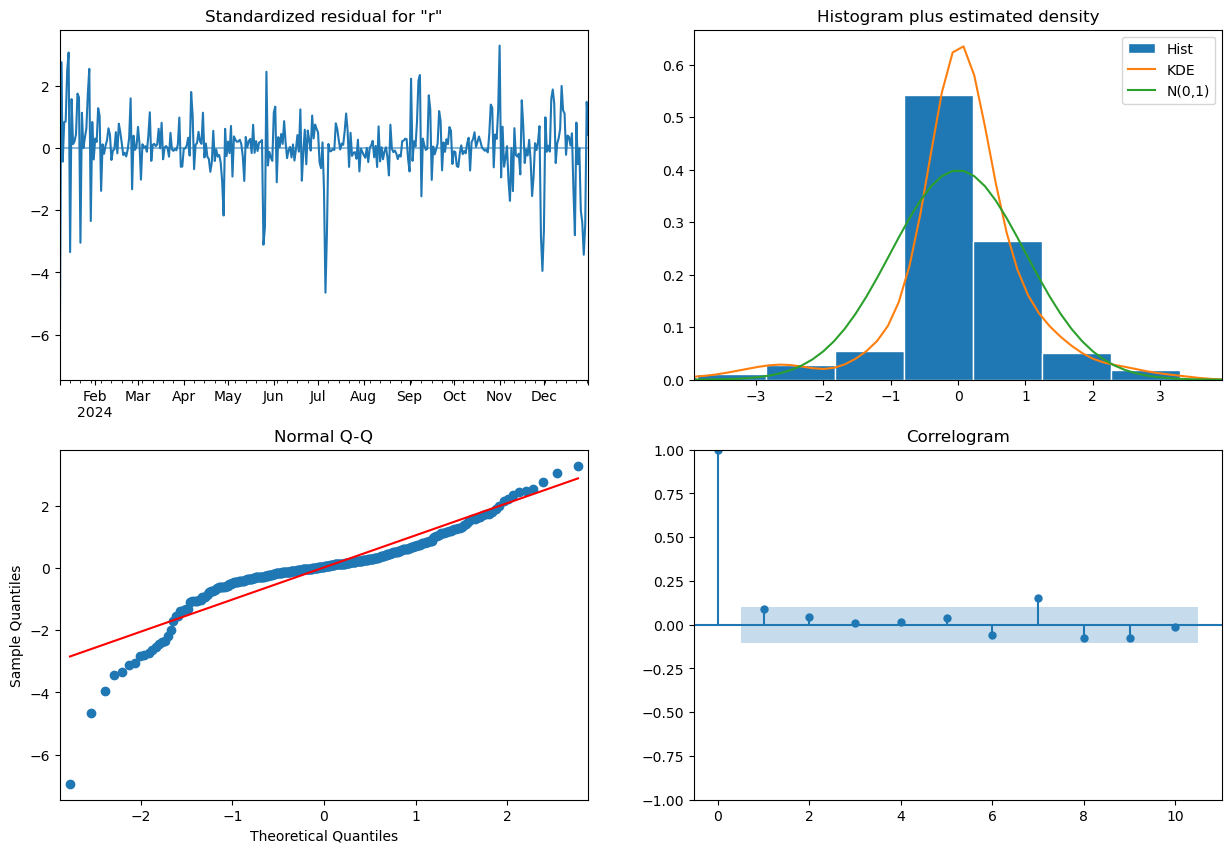

In [131]:
model_night_sarimax.plot_diagnostics(figsize=(15, 10))
plt.show()

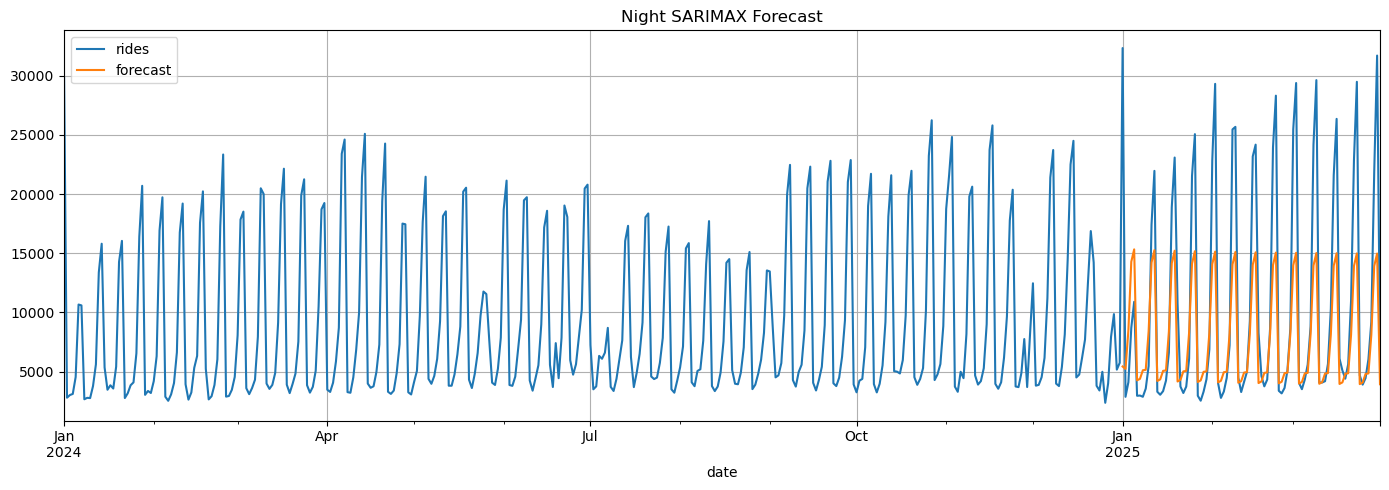

In [132]:
df_night_sarimax = plot_forecast(df_night_base, forecast_night_sarimax, len(night_df_train), title='Night SARIMAX Forecast')


In [133]:
evaluate_forecast(night_df_test.rides, forecast_night_sarimax, False)


{'mae': 4012.7563281473886, 'mape': 0.3203629366059169}

## Fit modelu AUTOARIMA

In [135]:
model_night_autoarima = auto_arima(
    night_df_train.rides,
    seasonal=False,       # jeśli nie modelujesz sezonowości (ARIMA, nie SARIMA)
    stepwise=False        # szybsze dopasowanie
)


print(model_night_autoarima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  366
Model:               SARIMAX(1, 0, 4)   Log Likelihood               -3642.960
Date:                Sat, 14 Jun 2025   AIC                           7297.920
Time:                        11:47:31   BIC                           7321.335
Sample:                    01-01-2024   HQIC                          7307.224
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9998      0.000   8060.121      0.000       1.000       1.000
ma.L1         -0.5778      0.035    -16.352      0.000      -0.647      -0.508
ma.L2         -0.5456      0.031    -17.410      0.0

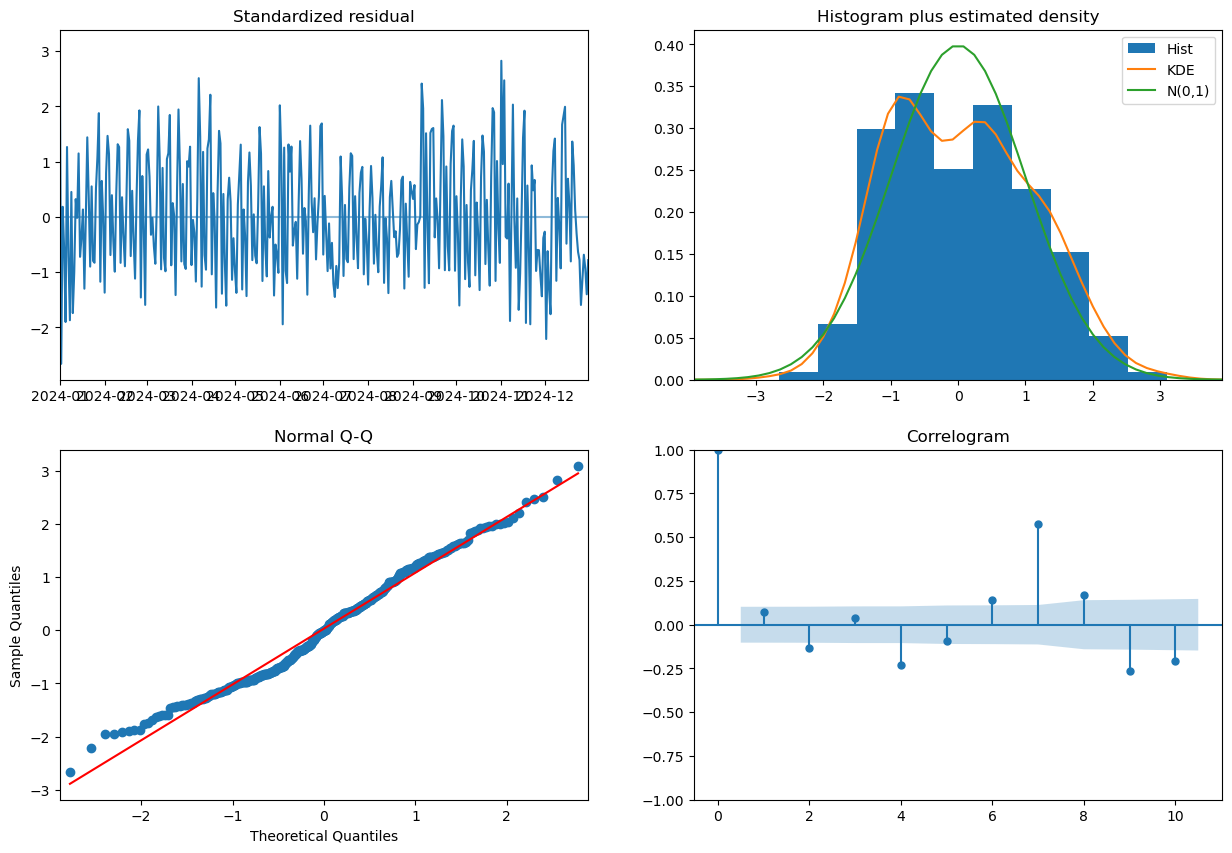

In [136]:
model_night_autoarima.plot_diagnostics(figsize=(15, 10))
plt.show()

In [137]:
forecast_night_autoarima = model_night_autoarima.predict(len(night_df_test.rides))


<Axes: title={'center': 'Night AUTOARIMA Forecast'}, xlabel='date'>

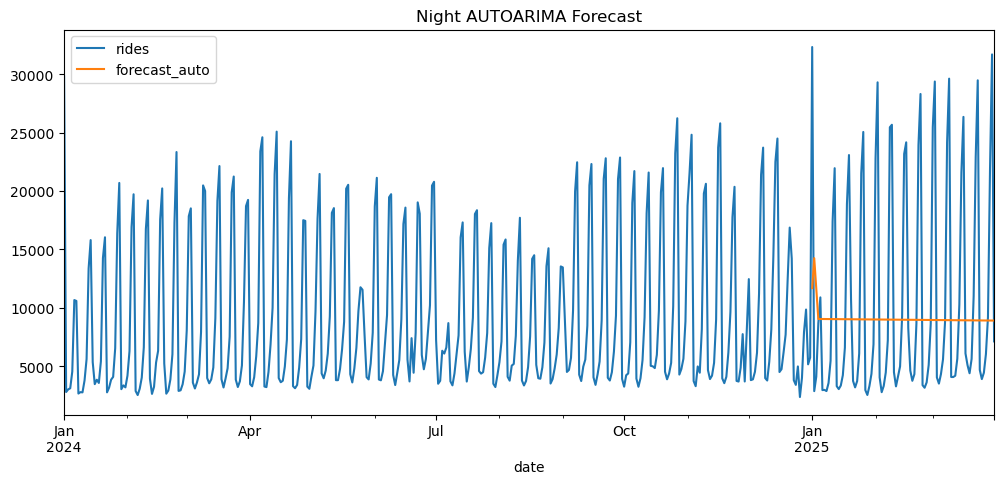

In [311]:
df_night_autoarima = df_night_base.copy()
df_night_autoarima['forecast_auto'] = [None]*len(night_df_train.rides) + list(forecast_night_autoarima)
df_night_autoarima[['rides', 'forecast_auto']].plot(figsize=(12, 5), title='Night AUTOARIMA Forecast')

In [139]:
evaluate_forecast(night_df_test.rides, forecast_night_autoarima, False)


{'mae': 7434.34547612439, 'mape': 0.956433203054936}

## Fit modelu AUTOARIMA z sezonowością

In [141]:
model_night_autosarima = auto_arima(
    night_df_train.rides,
    seasonal=True,
    m=7, 
    stepwise=False       
)


print(model_night_autosarima.summary())

                                       SARIMAX Results                                        
Dep. Variable:                                      y   No. Observations:                  366
Model:             SARIMAX(0, 0, 1)x(1, 0, [1, 2], 7)   Log Likelihood               -3492.162
Date:                                Sat, 14 Jun 2025   AIC                           6996.324
Time:                                        11:48:31   BIC                           7019.740
Sample:                                    01-01-2024   HQIC                          7005.629
                                         - 12-31-2024                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   7460.6910    961.967      7.756      0.000    5575.271    9346.111
ma.

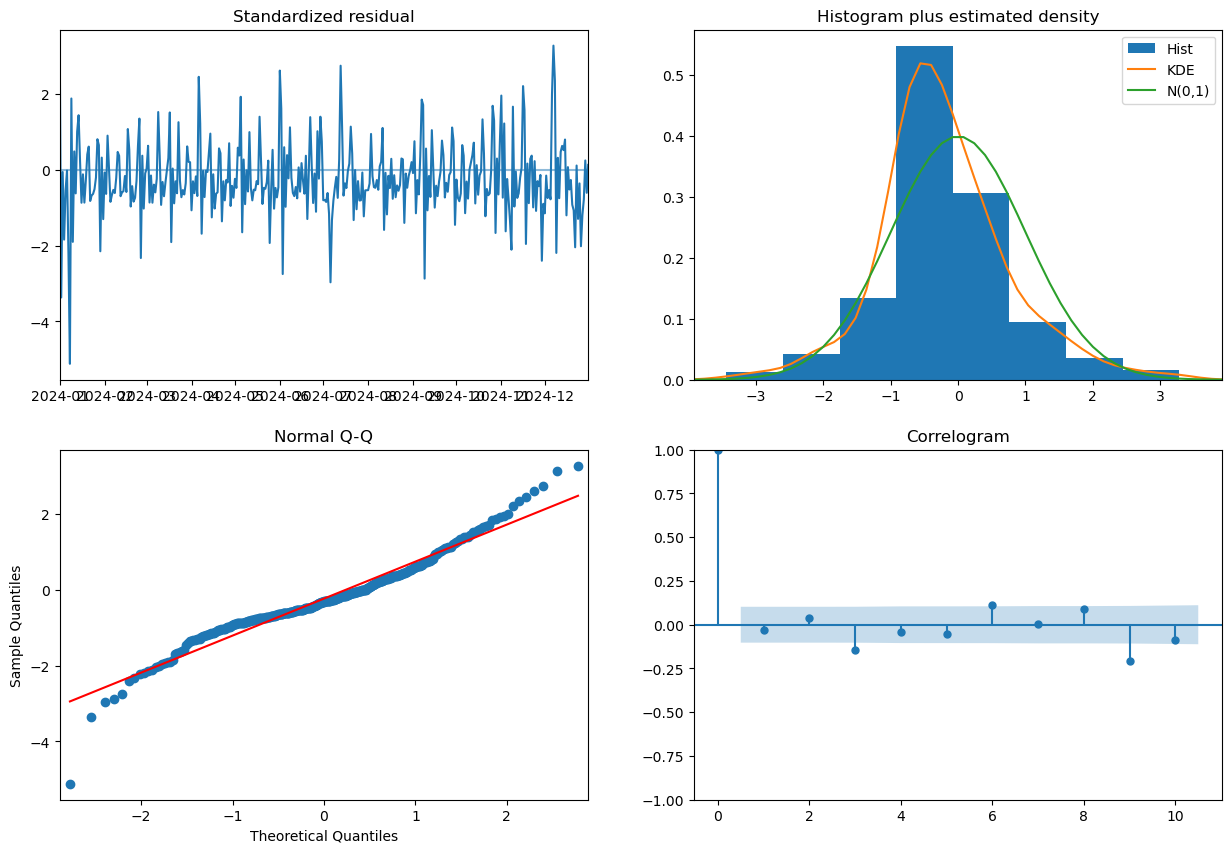

In [142]:
model_night_autosarima.plot_diagnostics(figsize=(15, 10))
plt.show()

In [143]:
forecast_night_autosarima = model_night_autosarima.predict(len(night_df_test.rides))


<Axes: title={'center': 'Night AUTOSARIMA Forecast'}, xlabel='date'>

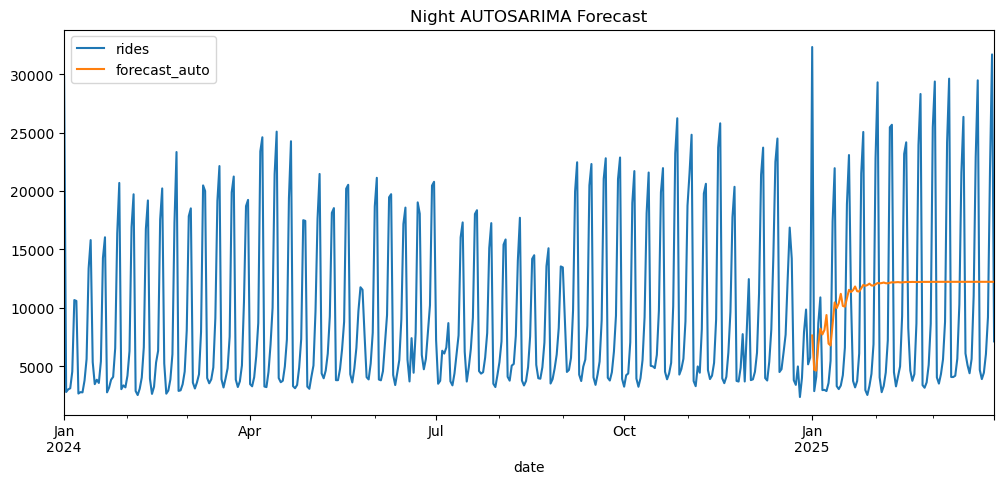

In [313]:
df_night_autosarima = df_night_base.copy()
df_night_autosarima['forecast_auto'] = [None]*len(night_df_train.rides) + list(forecast_night_autosarima)
df_night_autosarima[['rides', 'forecast_auto']].plot(figsize=(12, 5), title='Night AUTOSARIMA Forecast')

In [145]:
evaluate_forecast(night_df_test.rides, forecast_night_autosarima, False)


{'mae': 8209.843908381012, 'mape': 1.2475701786082989}

# Porównanie modeli ARIMA dla zmiennej `night`

In [315]:
stats_night_arima      = evaluate_forecast(night_df_test.rides, forecast_night_arima, False)
stats_night_sarima     = evaluate_forecast(night_df_test.rides, forecast_night_sarima, False)
stats_night_sarimax    = evaluate_forecast(night_df_test.rides, forecast_night_sarimax, False)
stats_night_autoarima = evaluate_forecast(night_df_test.rides, forecast_night_autoarima, False)
stats_night_autosarima    = evaluate_forecast(night_df_test.rides, forecast_night_autosarima, False)

# Zbieramy je do jednej listy
all_night_stats = [
    {'model': 'ARIMA',      **stats_night_arima},
    {'model': 'SARIMA',     **stats_night_sarima},
    {'model': 'autoARIMA',  **stats_night_autoarima},
    {'model': 'SARIMAX',    **stats_night_sarimax},
    {'model': 'autoSARIMA',    **stats_night_autosarima}
]

# Tworzymy DataFrame
comparison_night_df = pd.DataFrame(all_night_stats)


comparison_night_df = comparison_night_df.sort_values(by='mae')
comparison_night_df

model          mae      mape
1      SARIMA  4012.755860  0.320363
3     SARIMAX  4012.756328  0.320363
0       ARIMA  4723.594603  0.509050
2   autoARIMA  7434.345476  0.956433
4  autoSARIMA  8209.843908  1.247570

Najniższy błąd predykcji dla nocnych przejazdów uzyskały modele SARIMA i SARIMAX, które osiągnęły bardzo zbliżone wyniki (MAE około 4013 i MAPE około 32 procent). Wyraźnie gorzej wypadł klasyczny model ARIMA, którego błąd był o połowę większy. Najsłabsze rezultaty dały modele automatyczne (autoARIMA i autoSARIMA), których błędy przekraczały nawet 95 procent. Wyniki pokazują, że uwzględnienie sezonowości tygodniowej jest kluczowe dla jakości prognoz, a proste modele automatyczne nie radzą sobie dobrze z charakterystyką danych nocnych. Rekomendowane jest stosowanie modelu SARIMA lub SARIMAX, ponieważ zapewniają najniższy błąd prognozowania dla tego typu danych.

Błędy prognozy dla przejazdów nocnych są wyraźnie większe niż dla prognoz opartych na danych całodobowych. Jedną z głównych przyczyn może być znacznie większa zmienność oraz niższa przewidywalność ruchu w porze nocnej – liczba przejazdów nocą silniej podlega wpływom nieregularnych wydarzeń (np. imprez, świąt, pogody, incydentów lokalnych). Dodatkowo, relatywnie mniejsza liczba kursów nocnych oznacza, że nawet niewielkie bezwzględne odchylenia powodują wyższy błąd procentowy.

Aby zwiększyć jakość predykcji, należy rozważyć przetestowanie innych metod (modele z uczeniem maszynowym np XGBoost, rozwinięte modele ARIMA jak Prophet), wzbogacenie modelu o dodatkowe cechy (np. ręczne wskazanie świąt, wydarzeń itp.). Możliwe też że błędy wynikają z małej ilości danych wejściowych. Jedną z możliwości jest także zmiana danych wejściowych na dane logarytmiczne, która mogą lepiej uchwycić zmienność, co jest przedstawione w następnym segmencie.

# Model dla danych logarytmicznych dla zmiennej `night`

## Sprawdzenie stacjonarności danych logarytmicznych

In [153]:
result = adfuller(night_df['log_rides'].dropna())
print('ADF stat:', result[0])
print('p-value:', result[1])

ADF stat: -3.8764246105653664
p-value: 0.002215364933840484


p<0.05, d=0

In [155]:
# test ADF (Augmented Dickey–Fuller) dla sezonowosci
seasonal_diff_log = night_df_train.log_rides - night_df_train.log_rides.shift(7)
seasonal_diff_log = seasonal_diff.dropna()
adf_night_season_log = adfuller(seasonal_diff_log)
print(f'p-value: {adf_night_season_log[1]}')

p-value: 1.1932157485511432e-10


p<0.05, D=1

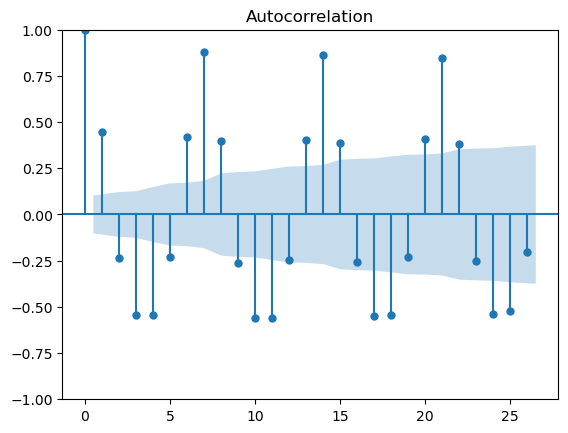

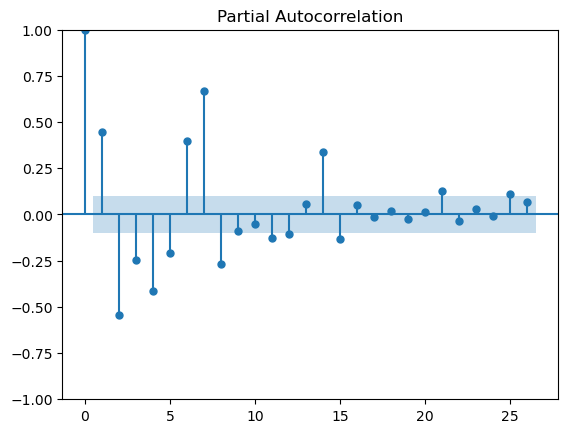

In [157]:
acf_night = plot_acf(night_df_train.log_rides)
pacf_night = plot_pacf(night_df_train.log_rides)

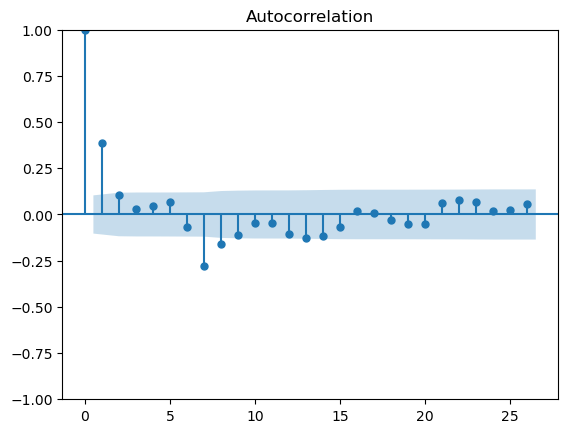

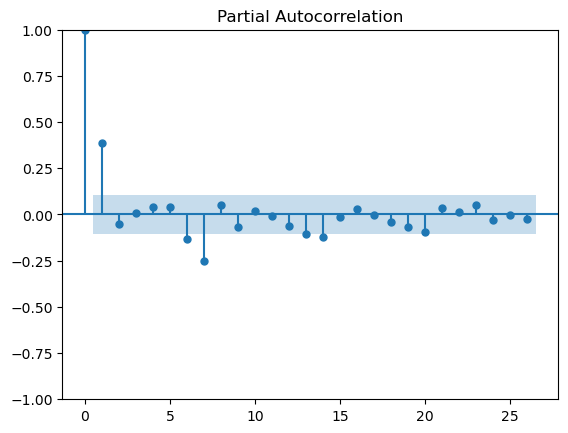

In [158]:
acf_night = plot_acf(seasonal_diff_log)
pacf_night = plot_pacf(seasonal_diff_log)

## Model SARIMAX z danymi logarytmicznymi dla `night`

In [160]:
forecast_night_sarimax_log, model_night_sarimax_log = train_sarimax(night_df_train.log_rides, night_df_test.log_rides,night_exog_train, night_exog_test, order=(2,0,2), seasonal_order=(2,1,2,7))
print(model_night_sarimax_log.summary())

C:\Users\krack\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\krack\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                         log_rides   No. Observations:                  366
Model:             SARIMAX(2, 0, 2)x(2, 1, 2, 7)   Log Likelihood                  18.453
Date:                           Sat, 14 Jun 2025   AIC                            -16.905
Time:                                   11:48:35   BIC                             21.928
Sample:                               01-01-2024   HQIC                            -1.463
                                    - 12-31-2024                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
is_weekend  1.616e-05   6334.029   2.55e-09      1.000   -1.24e+04    1.24e+04
ar.L1          1.4313      0.156      9.159

C:\Users\krack\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


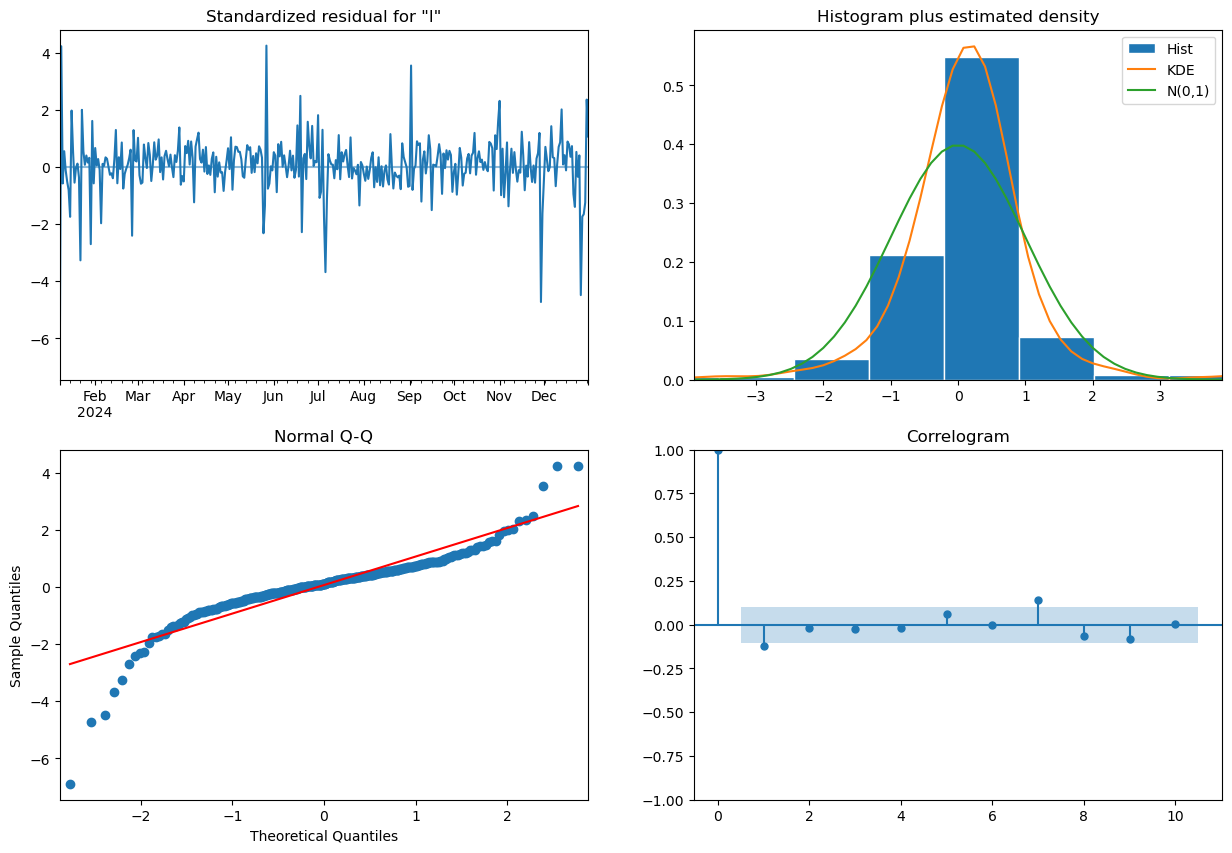

In [161]:
model_night_sarimax_log.plot_diagnostics(figsize=(15, 10))
plt.show()

In [162]:
forecast_night_sarimax_exp = np.exp(forecast_night_sarimax_log)

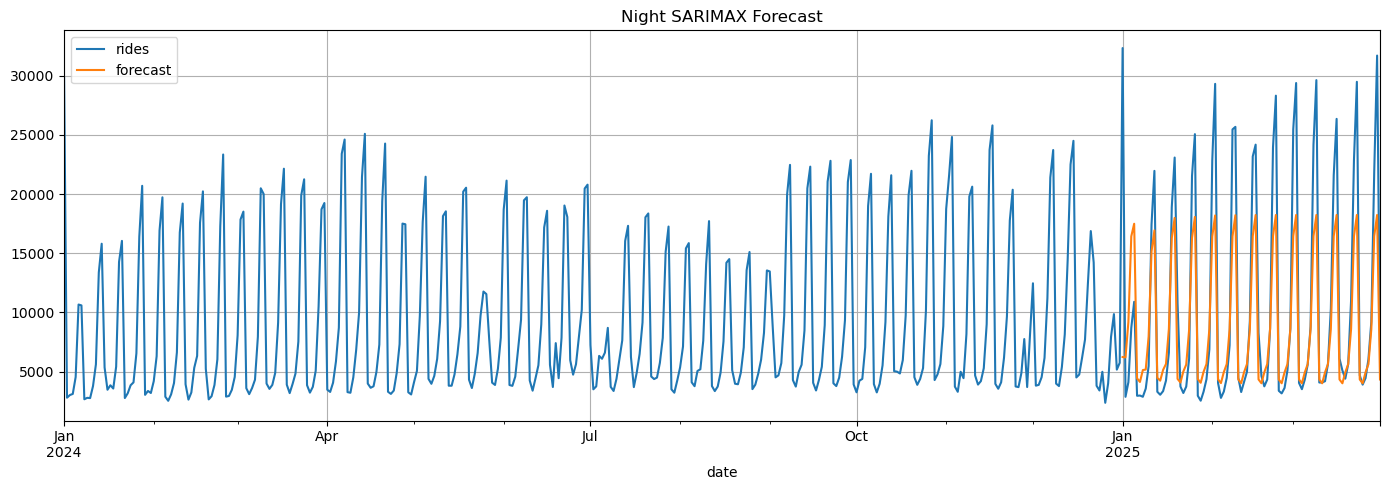

In [163]:
df_night_sarimax_log = plot_forecast(df_night_base, forecast_night_sarimax_exp, len(night_df_train), title='Night SARIMAX Forecast')

In [164]:
evaluate_forecast(night_df_test.rides, forecast_night_sarimax_exp, False)


{'mae': 3344.0831973793456, 'mape': 0.30332512477290796}

In [317]:
stats_night_sarimax_log      = evaluate_forecast(night_df_test.rides, forecast_night_sarimax_exp, False)

# Zbieramy je do jednej listy
all_night_stats_log = [
    {'model': 'SARIMAX',     **stats_night_sarimax},
    {'model': 'SARIMAX_log',     **stats_night_sarimax_log}
]

# Tworzymy DataFrame
comparison_night_df1 = pd.DataFrame(all_night_stats_log)


comparison_night_df1 = comparison_night_df1.sort_values(by='mae')
comparison_night_df1

model          mae      mape
1  SARIMAX_log  3344.083197  0.303325
0      SARIMAX  4012.756328  0.320363

Dodanie logarytmu pomogło predykcji, wynik poprawił się o dwa p.p. Nie jest to dalej jednak model, który nadaje się do predykcji w realnym środowisku produkcyjnym, więc poprzednie sugestie są lepsze do rozważenia (zmiana modelu lub dodanie dodatkowych informacji).

# Wnioski końcowe


Przeprowadzona analiza pozwoliła zidentyfikować istotne cechy zachowania liczby przejazdów w czasie, w tym wyraźną sezonowość tygodniową oraz umiarkowany trend wzrostowy. Modele prognostyczne oparte na rodzinie ARIMA, szczególnie SARIMA i SARIMAX, okazały się skuteczne w przewidywaniu dziennej liczby przejazdów – osiągając satysfakcjonujący poziom błędu (MAPE ~12%).

Prognozowanie liczby przejazdów nocnych okazało się trudniejsze ze względu na większą zmienność i silny wpływ incydentalnych zdarzeń. Mimo zastosowania transformacji logarytmicznej i sezonowych modeli, dokładność tych prognoz pozostała ograniczona. Poziom błędu (MAPE ~30%) wyklucza model z użycia w środowisku biznesowym, należałoby rozważyć innej podejście do problemu.

Rekomenduje się dalsze badania z wykorzystaniem dodatkowych zmiennych egzogenicznych oraz alternatywnych metod (np. model Prophet czy modele uczenia maszynowego), które mogą lepiej uchwycić nietypowe wzorce. Ogólnie jednak projekt uważam za sukces, dostarczył cennych wniosków i stanowi dobrą podstawę do dalszego rozwijania rozwiązań predykcyjnych w obszarze analizy zapotrzebowania na przejazdy.